# **Precision and Recall for Time Series**

Anomaly detection in time series data has traditionally focused on identifying point-based anomalies, which are deviations occurring at a single moment in time. However, many real-world applications involve range-based anomalies, where anomalous behavior spans across a continuous period of time. To address this limitation, this notebook reproduces the paper [Precision and Recall for Time Series](https://arxiv.org/abs/1803.03639), that introduces a novel mathematical framework for evaluating the performance of time series classification algorithms.

The proposed model extends the classical Precision and Recall metrics to account for range-based anomalies, offering a more comprehensive evaluation methodology. Additionally, it incorporates customization capabilities, allowing domain-specific preferences to be incorporated into the evaluation process.

In this notebook, we will:

- Implement the evaluation framework described in the paper.
- Benchmark naive and optimized approaches for computing range-based Precision and Recall.
- Reproduce and visualize the results presented in the paper.

This project aims to validate the proposed methodology and provide a deeper understanding of how range-based metrics can enhance the evaluation of anomaly detection algorithms in time series data.

## **Precision and recall for ranges**

### **Definition**

The new scoring model considers the following aspects:

- Existence: Detecting the presence of an anomaly, even by predicting a single point, holds value for many applications.
- Size: A larger correctly predicted portion of the anomaly increases the recall score.
- Position: The relative position of the correctly predicted portion within the anomaly range may also be important, depending on the application.
- Cardinality: Identifying an anomaly with a single prediction is often more valuable than fragmented detections across multiple ranges.

## Notation
| Symbol | Description |
|--------|-------------|
| $R, R_i$ | Set of real anomaly ranges, the $i^{th}$ real anomaly range |
| $P, P_j$ | Set of predicted anomaly ranges, the $j^{th}$ predicted anomaly range |
| $N, N_r, N_p$ | Number of all points, number of real anomaly ranges, number of predicted anomaly ranges |
| $\alpha$ | Relative weight of existence reward |
| $\gamma(), \omega(), \delta()$ | Overlap cardinality function, overlap size function, positional bias function |

## Formulas

### Recall
$$Recall_T(R,P) = \frac{\sum_{i=1}^{N_r} Recall_T(R_i,P)}{N_r}$$

$$Recall_T(R_i,P) = \alpha \times ExistenceReward(R_i,P) + (1-\alpha) \times OverlapReward(R_i,P)$$

$$ExistenceReward(R_i,P) = \begin{cases}
1, \text{ if } \sum_{j=1}^{N_p} |R_i \cap P_j| \geq 1 \\
0, \text{ otherwise}
\end{cases}$$

$$OverlapReward(R_i,P) = CardinalityFactor(R_i,P) \times \sum_{j=1}^{N_p} \omega(R_i, R_i \cap P_j, \delta)$$

$$CardinalityFactor(R_i,P) = \begin{cases}
1, \text{ if } R_i \text{ overlaps with at most one } P_j \in P \\
\gamma(R_i,P), \text{ otherwise}
\end{cases}$$

### Precision
$$Precision_T(R,P) = \frac{\sum_{i=1}^{N_p} Precision_T(R,P_i)}{N_p}$$

$$Precision_T(R,P_i) = CardinalityFactor(P_i,R) \times \sum_{j=1}^{N_r} \omega(P_i, P_i \cap R_j, \delta)$$


The following cell defines our Evaluator class, which encompasses all the necessary functions to compute the range-based precision and recall scores.

In [1]:
import numpy as np

class Evaluator:
    def __init__(self, real_anomalies, predicted_anomalies, alpha=0, gamma_p='one', gamma_r='one', delta_p='flat', delta_r='flat'):
        self.real_anomalies = real_anomalies
        self.predicted_anomalies = predicted_anomalies
        self.alpha_r = alpha
        self.gamma_p = gamma_p
        self.gamma_r = gamma_r
        self.delta_p = delta_p
        self.delta_r = delta_r

    def show_real_anomalies(self):
        print("Real Anomalies:")
        for start, end in self.real_anomalies:
            print(f"[{start}, {end}]")

    def show_predicted_anomalies(self):
        print("Predicted Anomalies:")
        for start, end in self.predicted_anomalies:
            print(f"[{start}, {end}]")


    def gamma_function(self, gamma, overlap, metric, precision_or_recall):
        if gamma == 'one':
            return 1.0
        elif gamma == 'reciprocal':
            return 1.0 / overlap if overlap > 1 else 1.0
        else:
            print(f"Warning: Invalid overlap cardinality function for {precision_or_recall} = {gamma}. Defaulting to 'one'.")
            return 1.0

    def calculate_gamma(self, overlap, metric):
        # Select the gamma value based on precision/recall
        if metric == 'precision':
            return self.gamma_function(self.gamma_p, overlap, metric, "precision")
        elif metric == 'recall':
            return self.gamma_function(self.gamma_r, overlap, metric, "recall")
        else:
            print(f"Warning: Invalid metric {metric} in calculate_gamma")
            return 1.0

    def delta_function(self, delta, t, anomaly_length, metric, precision_or_recall):
        if delta == 'flat':
            return 1.0
        elif delta == 'front':
            return float(anomaly_length - t + 1)
        elif delta == 'middle':
            return float(t if t <= anomaly_length / 2 else anomaly_length - t + 1)
        elif delta == 'back':
            return float(t)
        else:
            print(f"Warning: Invalid positional bias for {precision_or_recall} = {delta}. Defaulting to 'flat'.")
            return 1.0

    def calculate_delta(self, t, anomaly_length, metric):
        # Select the delta value based on precision/recall
        if metric == 'precision':
            return self.delta_function(self.delta_p, t, anomaly_length, metric, "precision")
        elif metric == 'recall':
            return self.delta_function(self.delta_r, t, anomaly_length, metric, "recall")
        else:
            print(f"Warning: Invalid metric {metric} in calculate_delta")
            return 1.0

    def calculate_omega(self, rrange, overlap, metric):
        # Calculate omega reward based on overlap and positional bias
        anomaly_length = rrange[1] - rrange[0] + 1
        total_positional_bias = 0
        max_positional_bias = 0

        for i in range(1, anomaly_length + 1):
            bias = self.calculate_delta(i, anomaly_length, metric)
            max_positional_bias += bias

            j = rrange[0] + i - 1
            if overlap[0] <= j <= overlap[1]:
                total_positional_bias += bias

        if max_positional_bias > 0:
            return total_positional_bias / max_positional_bias
        else:
            return 0

    def overlap_reward(self, r1, r2, overlap_count, metric):
        # Compute omega score based on range overlaps
        if r1[1] < r2[0] or r1[0] > r2[1]:
            return 0
        overlap_count[0] += 1
        overlap = (max(r1[0], r2[0]), min(r1[1], r2[1]))
        return self.calculate_omega(r1, overlap, metric)


    def compute_precision(self):
        if len(self.predicted_anomalies) == 0:
            return 0.0

        precision = 0.0
        for p_start, p_end in self.predicted_anomalies:
            omega_reward = 0
            overlap_count = [0]  # Using a list to pass by reference
            for r_start, r_end in self.real_anomalies:
                omega_reward += self.overlap_reward(
                    (p_start, p_end), (r_start, r_end), overlap_count, 'precision'
                )

            overlap_reward = self.calculate_gamma(overlap_count[0], 'precision') * omega_reward
            existence_reward = 1 if overlap_count[0] > 0 else 0
            precision += self.alpha_r * existence_reward + (1 - self.alpha_r) * overlap_reward

        return precision / len(self.predicted_anomalies)

    def compute_recall(self):
        if len(self.real_anomalies) == 0:
            return 0.0

        recall = 0.0
        for r_start, r_end in self.real_anomalies:
            omega_reward = 0
            overlap_count = [0]  
            for p_start, p_end in self.predicted_anomalies:
                omega_reward += self.overlap_reward(
                    (r_start, r_end), (p_start, p_end), overlap_count, 'recall'
                )

            overlap_reward = self.calculate_gamma(overlap_count[0], 'recall') * omega_reward
            existence_reward = 1 if overlap_count[0] > 0 else 0
            recall += self.alpha_r * existence_reward + (1.0 - self.alpha_r) * overlap_reward

        return recall / len(self.real_anomalies)

    


Let's examine the impact of these functions on the recall score: the overlap cardinality function, overlap size function, and positional bias function. For this, we will prepare simple datasets with different characteristics, including real anomalies and four distinct predictions: one with anomalies predicted towards the front, another with anomalies predicted towards the back, a third with centered predicted anomalies to evaluate the effect of selecting the appropriate positional bias function on the recall score. Additionally, a fragmented set of predictions will be created to analyze the influence of the overlap cardinality function (similar experiments can be conducted for precision).

In [2]:
real_anomalies = [(4, 15), (24, 35), (43, 56), (63, 82), (91, 105)]
front_predicted = [(4, 7), (24, 27), (43, 47), (63, 69), (91, 95)]
back_predicted = [(12, 15), (32, 35), (52, 56), (76, 82), (101, 105)]
centered_predicted = [(7, 12), (27, 32), (47, 52), (69, 76), (95, 101)]
fragmented_predicted = [(4,7),(8,9), (24,27), (28,29), (30,31), (43, 52), (63, 82), (91,99),(101,105)]

Running experiment for Front Predicted anomalies


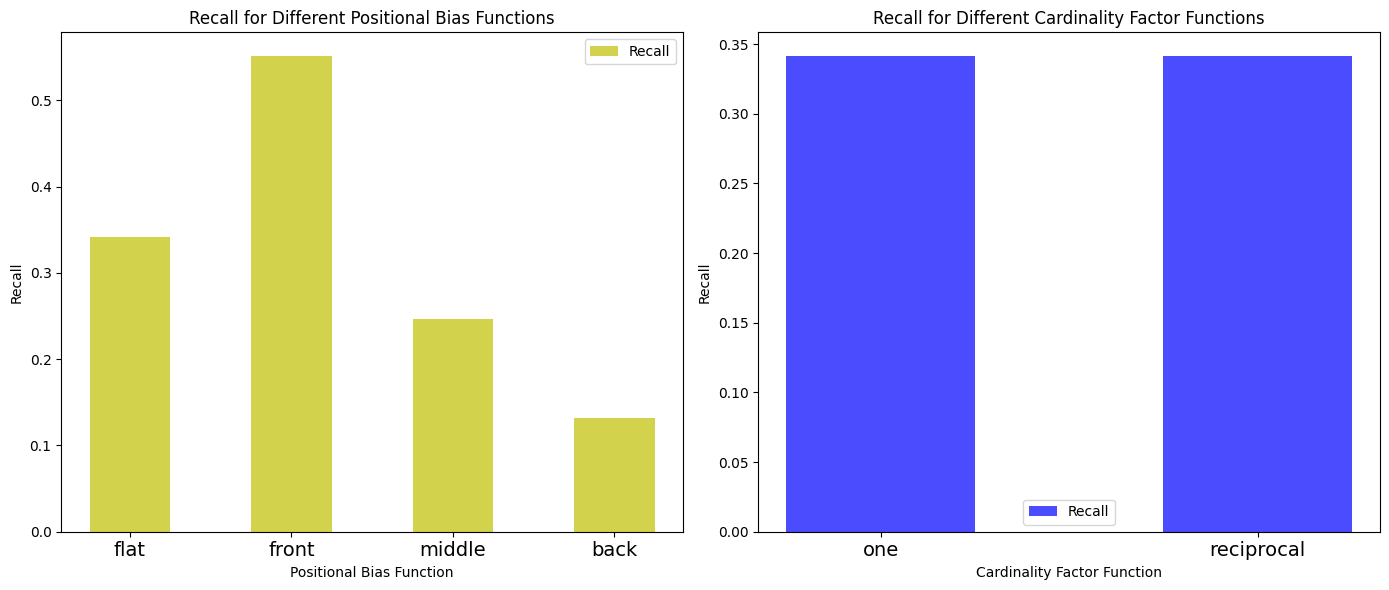

Running experiment for Back Predicted anomalies


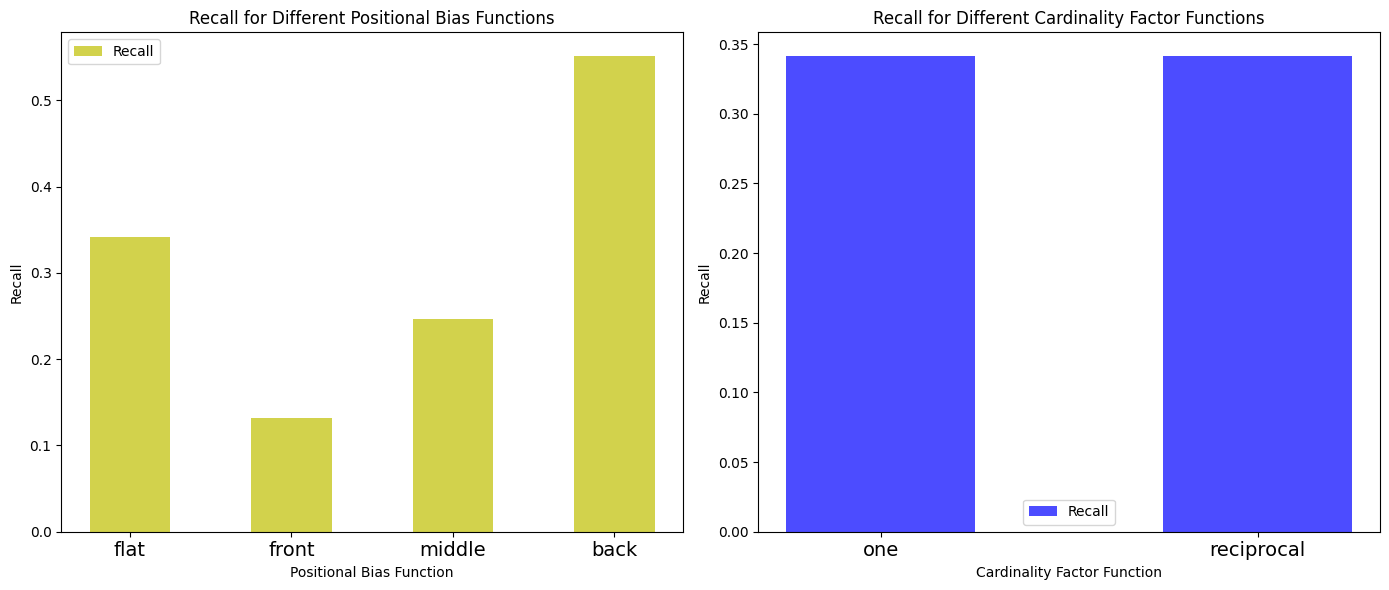

Running experiment for Centre Predicted anomalies


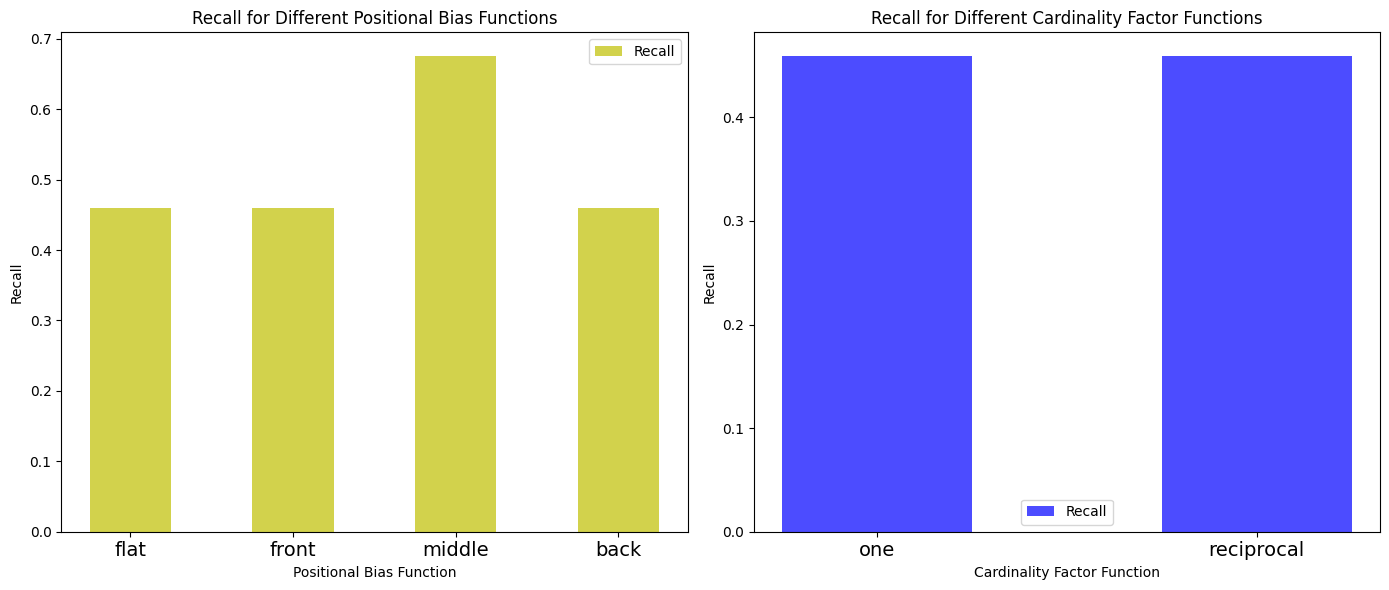

Running experiment for Fragmented Predictions


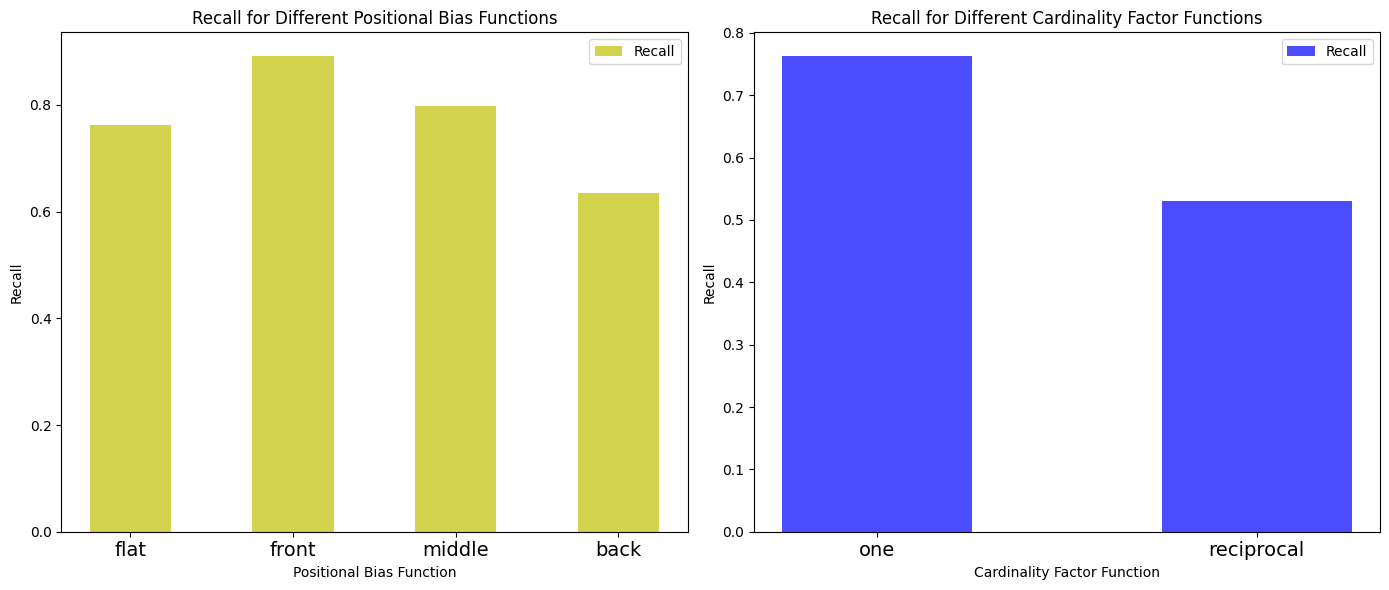

In [3]:

import random
import matplotlib.pyplot as plt
import numpy as np

# Positional Bias Experiment
def run_positional_bias_experiment(real_anomalies, predicted_anomalies):
    positional_bias_results = []
    for delta_p in ['flat', 'front', 'middle', 'back']:
        evaluator = Evaluator(real_anomalies, predicted_anomalies, delta_p=delta_p, delta_r=delta_p)
        recall = evaluator.compute_recall()
        positional_bias_results.append((delta_p, recall))
    return positional_bias_results

# Cardinality Factor Experiment
def run_cardinality_factor_experiment(real_anomalies, predicted_anomalies):
    cardinality_factor_results = []
    for gamma_p in ['one', 'reciprocal']:
        evaluator = Evaluator(real_anomalies, predicted_anomalies, gamma_p=gamma_p, gamma_r=gamma_p)
        recall = evaluator.compute_recall()
        cardinality_factor_results.append((gamma_p, recall))
    return cardinality_factor_results

# Plotting function for Positional Bias (Recall Only)
def plot_positional_bias(recall_pos_bias, pos_bias_types, ax):
    bar_width = 0.5
    index = np.arange(len(pos_bias_types))
    ax.bar(index, recall_pos_bias, bar_width, label='Recall', color='y', alpha=0.7)
    ax.set_xlabel('Positional Bias Function')
    ax.set_ylabel('Recall')
    ax.set_title('Recall for Different Positional Bias Functions')
    ax.set_xticks(index)
    ax.set_xticklabels(pos_bias_types,fontsize=14)
    ax.legend()

# Plotting function for Cardinality Factor (Recall Only)
def plot_cardinality_factor(recall_gamma, gamma_types, ax):
    bar_width = 0.5
    index = np.arange(len(gamma_types))
    ax.bar(index, recall_gamma, bar_width, label='Recall', color='b', alpha=0.7)
    ax.set_xlabel('Cardinality Factor Function')
    ax.set_ylabel('Recall')
    ax.set_title('Recall for Different Cardinality Factor Functions')
    ax.set_xticks(index)
    ax.set_xticklabels(gamma_types,fontsize=14)
    ax.legend()

# Running experiments for each dataset
datasets = [front_predicted, back_predicted, centered_predicted, fragmented_predicted]
dataset_names = ['Front Predicted anomalies', 'Back Predicted anomalies', 'Centre Predicted anomalies', 'Fragmented Predictions']

for dataset, name in zip(datasets, dataset_names):
    print(f"Running experiment for {name}")
    positional_bias_results = run_positional_bias_experiment(real_anomalies, dataset)
    pos_bias_types = [result[0] for result in positional_bias_results]
    recall_pos_bias = [result[1] for result in positional_bias_results]

    cardinality_factor_results = run_cardinality_factor_experiment(real_anomalies, dataset)
    gamma_types = [result[0] for result in cardinality_factor_results]
    recall_gamma = [result[1] for result in cardinality_factor_results]

    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the positional bias recall on the first subplot
    plot_positional_bias(recall_pos_bias, pos_bias_types, axes[0])

    # Plot the cardinality factor recall on the second subplot
    plot_cardinality_factor(recall_gamma, gamma_types, axes[1])

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()




### **Extention of the classical point-based model**

This new scoring model, with range-based precision and recall, effectively subsumes the classical point-based model when all ranges are represented as unit-sized ranges, using the arguments $\alpha = 0$, $\gamma() = 1$, and $\delta() = \text{Flat}$.

We demonstrate this with an experiment:

In [4]:
def point_based_precision_recall(real_anomalies, predicted_anomalies):
    # Convert the anomaly ranges into sets of individual points
    real_points = set()
    for start, end in real_anomalies:
        real_points.update(range(start, end + 1))  # Add all points in the range [start, end]
    
    predicted_points = set()
    for start, end in predicted_anomalies:
        predicted_points.update(range(start, end + 1))  # Add all points in the range [start, end]

    # Calculate point-based precision
    true_positive_points = len(real_points & predicted_points)  # Intersection of real and predicted points
    precision = true_positive_points / len(predicted_points) if predicted_points else 0.0

    # Calculate point-based recall
    recall = true_positive_points / len(real_points) if real_points else 0.0

    return precision, recall

In [5]:
# Example of real and predicted anomalies
real_anomalies = [(3, 3),(4,4),(5,5),(6,6), (8,8),(9,9),(10, 10)]  # List of real anomaly ranges
predicted_anomalies = [(1,1),(2,2),(3, 3),(4,4), (6,6),(7,7), (9,9),(10,10)]  # List of predicted anomaly ranges

# Create an Evaluator instance
evaluator = Evaluator(
    real_anomalies=real_anomalies,
    predicted_anomalies=predicted_anomalies,
    alpha=0,  
)

# Print the real and predicted anomalies
evaluator.show_real_anomalies()
evaluator.show_predicted_anomalies()


# Compute and print precision and recall using the range-based model
precision = evaluator.compute_precision()
recall = evaluator.compute_recall()

print(f"Range-based Precision: {precision}")
print(f"Range-based Recall: {recall}")

# Compute and print precision and recall using the traditional point-based model
precision, recall = point_based_precision_recall(real_anomalies, predicted_anomalies)

print(f"Point-based Precision: {precision}")
print(f"Point-based Recall: {recall}")

Real Anomalies:
[3, 3]
[4, 4]
[5, 5]
[6, 6]
[8, 8]
[9, 9]
[10, 10]
Predicted Anomalies:
[1, 1]
[2, 2]
[3, 3]
[4, 4]
[6, 6]
[7, 7]
[9, 9]
[10, 10]
Range-based Precision: 0.625
Range-based Recall: 0.7142857142857143
Point-based Precision: 0.625
Point-based Recall: 0.7142857142857143


## **Data Preparation**

Seven datasets were used alongside three different anomaly detectors. Since the goal of this project is to focus on the new scoring model rather than the anomaly detectors themselves, we utilized the real and predicted anomalies for each dataset from the paper's official GitHub repository. To compare the classical scoring model with the new range-based model, we prepared different versions of the data, representing anomalies as ranges, unit-size ranges, or points.

In [6]:
import os
import pandas as pd

def binary_to_point_based(binary_series):
    """
    Converts a binary series to point-based anomaly format.
    """
    points = [(i, i) for i in range(len(binary_series)) if binary_series[i] == 1]
    return points

def binary_to_range_based(binary_series):
    """
    Converts a binary series to range-based anomaly format.
    """
    ranges = []
    start = None
    
    for i in range(len(binary_series)):
        if binary_series[i] == 1:
            if start is None:
                start = i
        elif start is not None:
            ranges.append((start, i - 1))
            start = None
    
    # Handle case where last index is part of a range
    if start is not None:
        ranges.append((start, len(binary_series) - 1))
    
    return ranges

# Base directory and dataset details
base_path = "datasets\data"
datasets = ["aapl", "ecg", "machine_temp", "nyc_taxi", "sine", "space_shuttle", "timeguided"]


Now, we prepare the dataset for each anomaly detector : **LSTM-AD**, **Greenhouse**, **Luminol**

In [7]:
model = "lstm_ad"  # Target model

# Dictionary to store lstm_ad_data
lstm_ad_data = {}

# Process each dataset
for dataset in datasets:
    # Construct file paths
    real_path = os.path.join(base_path, dataset, f"{model}.real")
    pred_path = os.path.join(base_path, dataset, f"{model}.pred")
    
    # Load files
    real_anomalies = pd.read_csv(real_path, header=None).squeeze().tolist()
    pred_anomalies = pd.read_csv(pred_path, header=None).squeeze().tolist()

    # Convert to point-based and range-based
    real_points = binary_to_point_based(real_anomalies)
    pred_points = binary_to_point_based(pred_anomalies)
    real_ranges = binary_to_range_based(real_anomalies)
    pred_ranges = binary_to_range_based(pred_anomalies)
    
    # Store lstm_ad_data
    lstm_ad_data[dataset] = {
        "real_points": real_points,
        "pred_points": pred_points,
        "real_ranges": real_ranges,
        "pred_ranges": pred_ranges,
        "real_binary": real_anomalies,
        "pred_binary": pred_anomalies
    }

In [8]:
model = "greenhouse"  # Target model

greenhouse_data = {}

# Process each dataset
for dataset in datasets:
    real_path = os.path.join(base_path, dataset, f"{model}.real")
    pred_path = os.path.join(base_path, dataset, f"{model}.pred")
    
    real_anomalies = pd.read_csv(real_path, header=None).squeeze().tolist()
    pred_anomalies = pd.read_csv(pred_path, header=None).squeeze().tolist()

    real_points = binary_to_point_based(real_anomalies)
    pred_points = binary_to_point_based(pred_anomalies)
    real_ranges = binary_to_range_based(real_anomalies)
    pred_ranges = binary_to_range_based(pred_anomalies)
    
    greenhouse_data[dataset] = {
        "real_points": real_points,
        "pred_points": pred_points,
        "real_ranges": real_ranges,
        "pred_ranges": pred_ranges,
        "real_binary": real_anomalies,
        "pred_binary": pred_anomalies
    }

In [9]:
model = "luminol"  # Target model

luminol_data = {}

# Process each dataset
for dataset in datasets:
    real_path = os.path.join(base_path, dataset, f"{model}.real")
    pred_path = os.path.join(base_path, dataset, f"{model}.pred")
    
    real_anomalies = pd.read_csv(real_path, header=None).squeeze().tolist()
    pred_anomalies = pd.read_csv(pred_path, header=None).squeeze().tolist()

    real_points = binary_to_point_based(real_anomalies)
    pred_points = binary_to_point_based(pred_anomalies)
    real_ranges = binary_to_range_based(real_anomalies)
    pred_ranges = binary_to_range_based(pred_anomalies)
    
    luminol_data[dataset] = {
        "real_points": real_points,
        "pred_points": pred_points,
        "real_ranges": real_ranges,
        "pred_ranges": pred_ranges,
        "real_binary": real_anomalies,
        "pred_binary": pred_anomalies
    }

In [10]:
data = {"lstm_ad":lstm_ad_data, "greenhouse":greenhouse_data, "luminol":luminol_data}

We define some helper functions to assist with our data analysis: one function calculates statistics about the lengths of real and predicted anomalies, and another computes the average number of fragmented predictions for a single real anomaly (also referred to as cardinality).

In [11]:
def length_statistics(ranges):
    lengths = [end - start + 1 for start, end in ranges]
    return {
        'Average Length': sum(lengths) / len(lengths) if lengths else 0,
        'Min Length': min(lengths) if lengths else 0,
        'Max Length': max(lengths) if lengths else 0
    }

def average_cardinality(real_ranges, pred_ranges):
    cardinalities = []

    for real_start, real_end in real_ranges:
        overlapping_pred = [
            pred for pred in pred_ranges
            if max(real_start, pred[0]) <= min(real_end, pred[1])  # Overlap condition
        ]
        cardinalities.append(len(overlapping_pred))

    return sum(cardinalities) / len(cardinalities) if cardinalities else 0

def real_anomalies_predicted(real_ranges, pred_ranges):
    predicted_count = 0
    for real_start, real_end in real_ranges:
        # Check if any point in the real anomaly range is predicted
        for pred_start, pred_end in pred_ranges:
            if max(real_start, pred_start) <= min(real_end, pred_end):
                predicted_count += 1
                break  # Stop after finding one match for this real anomaly
    return predicted_count

The next cell defines a function that takes predictions from a specific anomaly detector, computes some statistics, and displays visualization plots:

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

def data_analysis(data):
    statistics_table = []
    num_datasets = len(data)
    rows = num_datasets
    cols = 1
    fig, axes = plt.subplots(rows, cols, figsize=(20, 3 * rows))
    if rows == 1:
        axes = [axes]
        
    for i, (dataset, data) in enumerate(data.items()):
        ax = axes[i]  # Current subplot
        real_ranges = data['real_ranges']
        pred_ranges = data['pred_ranges']
        
        for start, end in real_ranges:
            ax.plot([start, end], [0.6, 0.6], color='green', linewidth=3, label='Real' if start == real_ranges[0][0] else "")
        for start, end in pred_ranges:
            ax.plot([start, end], [0.4, 0.4], color='red', linewidth=2, label='Predicted' if start == pred_ranges[0][0] else "")
    
        ax.set_title(dataset)
        ax.set_yticks([0, 0.4, 0.6, 1])
        ax.set_yticklabels([' ', 'Predicted', 'Real', ' '])
        ax.set_xlabel('Time')
        ax.grid(True)
        ax.legend()
    
        num_real_anomalies = len(real_ranges)
        num_pred_anomalies = len(pred_ranges)
        num_real_anomalies_predicted = real_anomalies_predicted(real_ranges, pred_ranges)
        real_stats = length_statistics(real_ranges)
        pred_stats = length_statistics(pred_ranges)
        precision, recall = point_based_precision_recall(real_ranges, pred_ranges)
        avg_cardinality = average_cardinality(real_ranges, pred_ranges)
        statistics_table.append({
            'Dataset': dataset,
            'Num Real': num_real_anomalies,
            'Num Predicted': num_pred_anomalies,
            'Real Anomalies Predicted': num_real_anomalies_predicted, # At least one detected point
            'Real Avg Length': f"{real_stats['Average Length']:.2f}",
            'Real Min Length': real_stats['Min Length'],
            'Real Max Length': real_stats['Max Length'],
            'Pred Avg Length': f"{pred_stats['Average Length']:.2f}",
            'Pred Min Length': pred_stats['Min Length'],
            'Pred Max Length': pred_stats['Max Length'],
            'Precision': f"{precision:.2f}",
            'Recall': f"{recall:.2f}",
            'Avg Cardinality': f"{avg_cardinality:.2f}"
        })
    
    plt.tight_layout()
    plt.show()
    
    df = pd.DataFrame(statistics_table)
    print(tabulate(df, headers='keys', tablefmt='grid')) 

### **LSTM-AD Predictions**

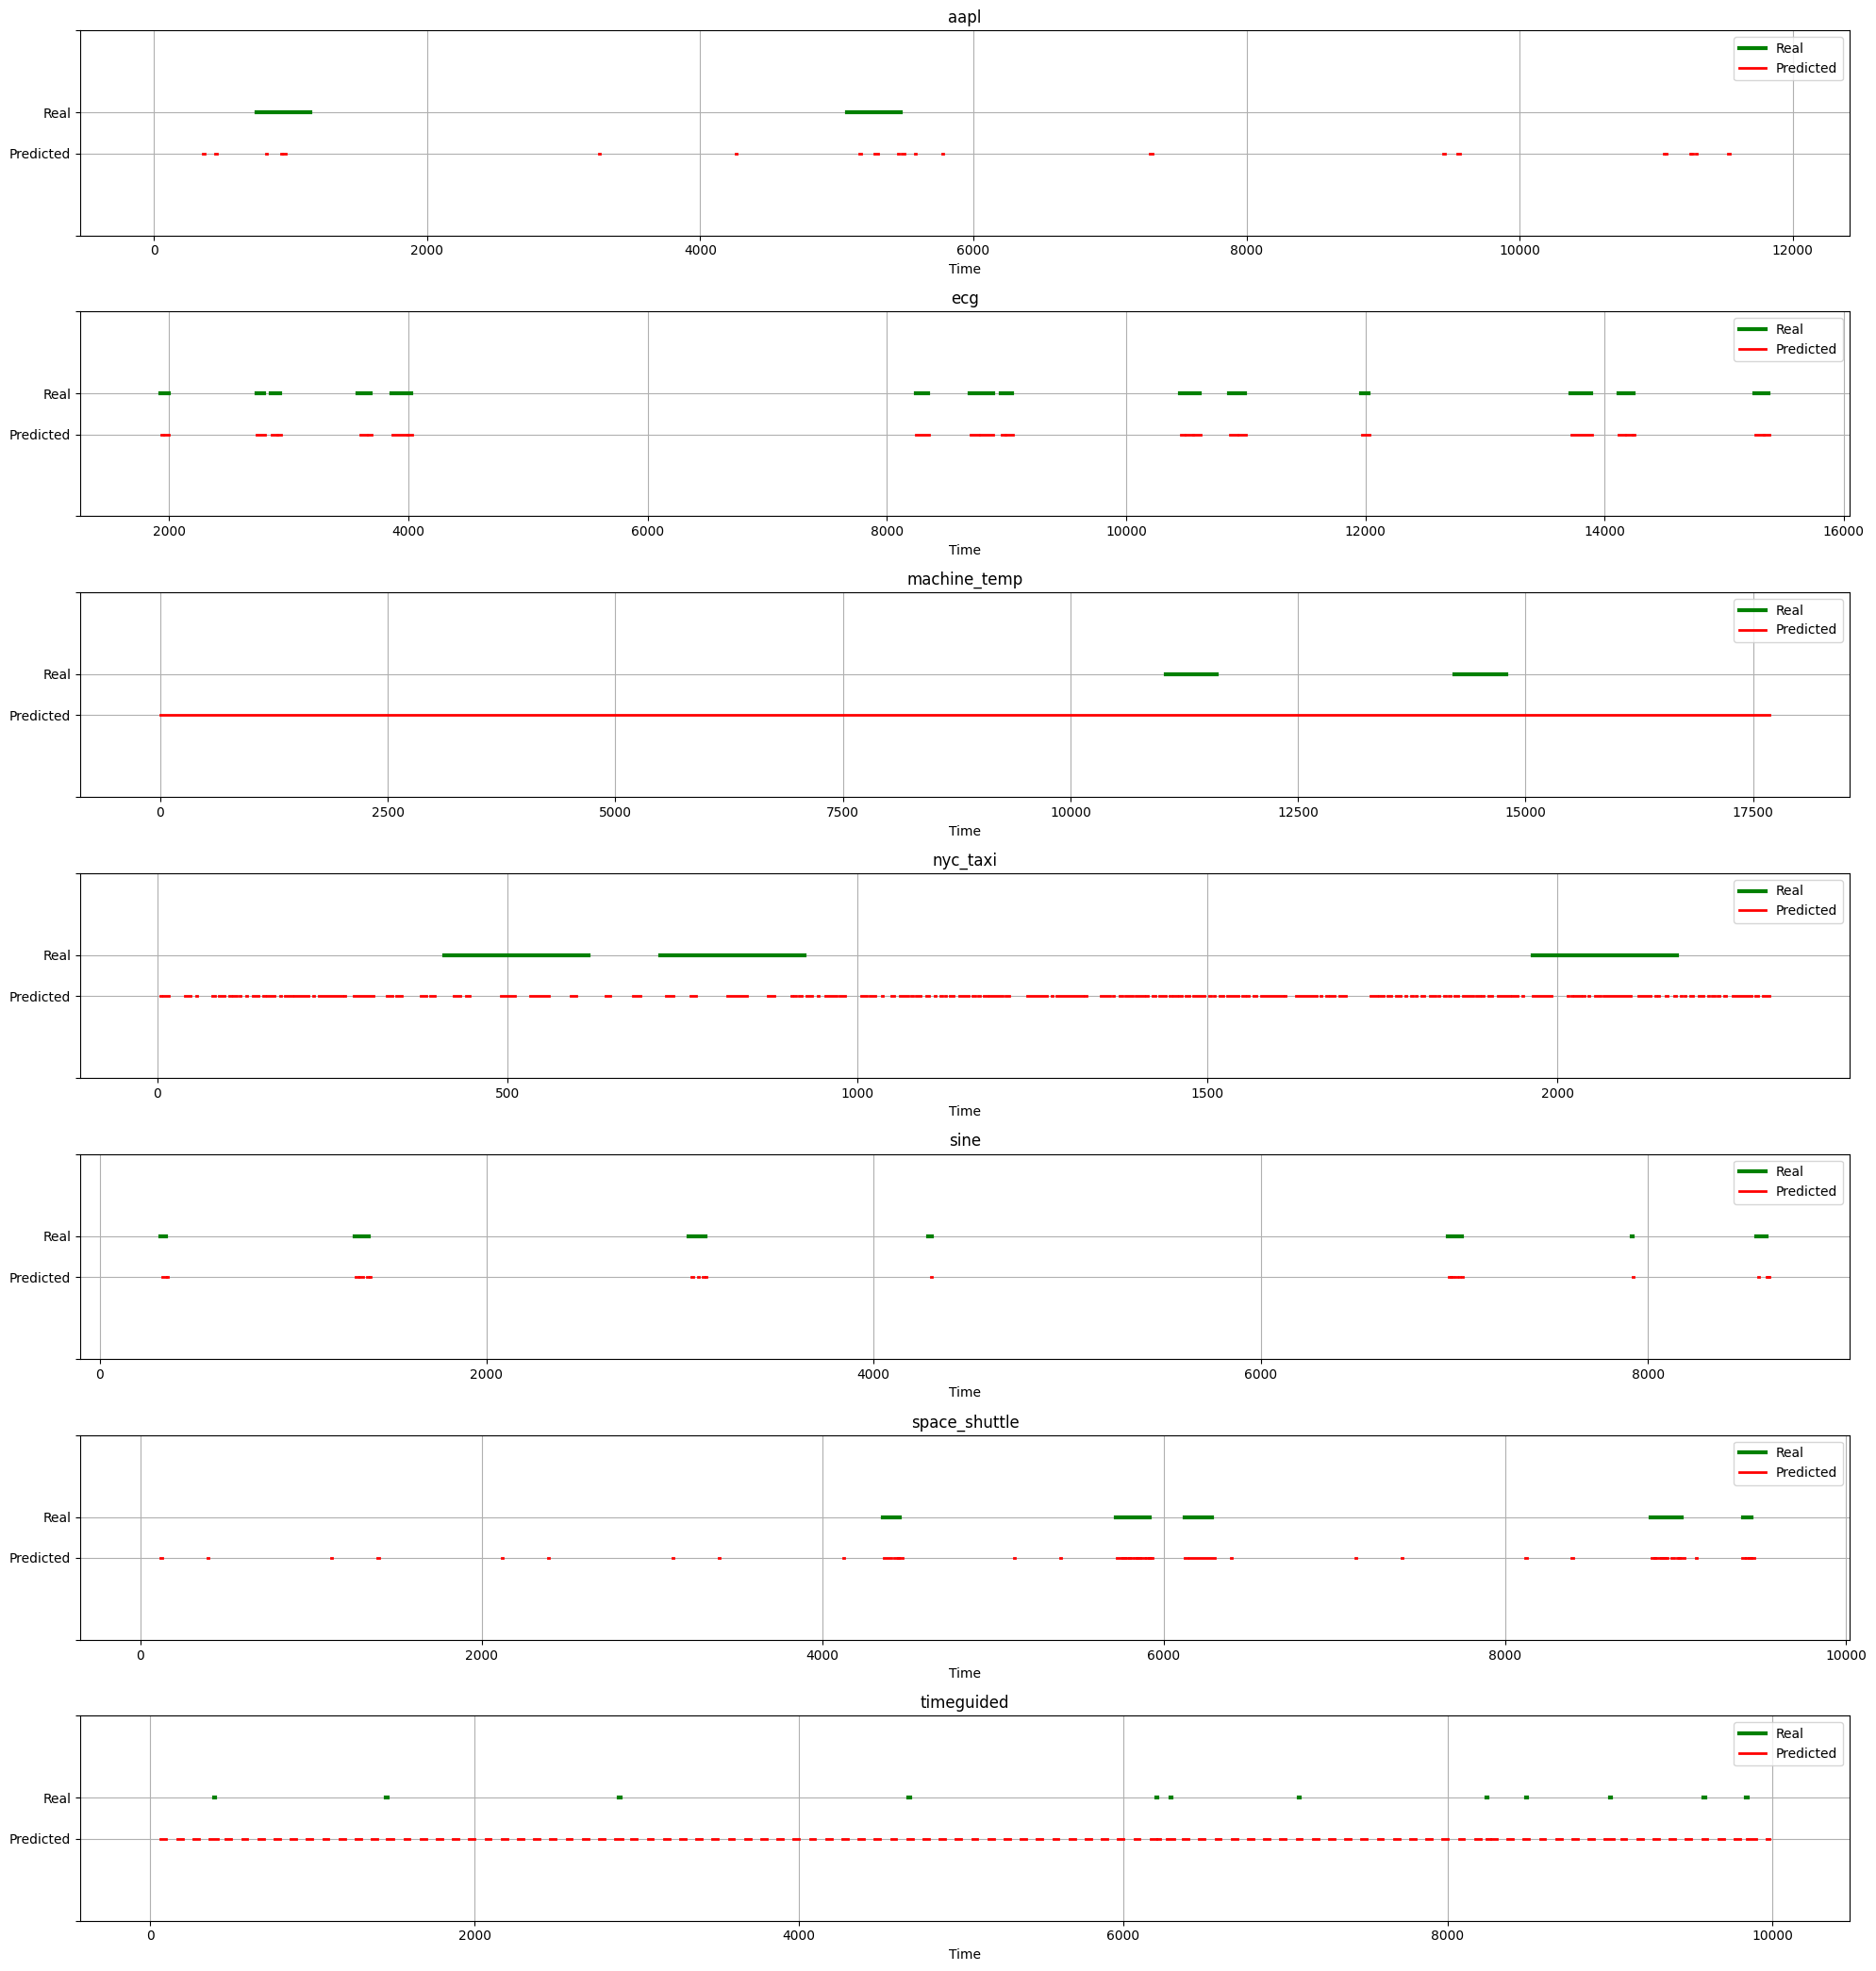

+----+---------------+------------+-----------------+----------------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------+----------+-------------------+
|    | Dataset       |   Num Real |   Num Predicted |   Real Anomalies Predicted |   Real Avg Length |   Real Min Length |   Real Max Length |   Pred Avg Length |   Pred Min Length |   Pred Max Length |   Precision |   Recall |   Avg Cardinality |
+====+===============+============+=================+============================+===================+===================+===================+===================+===================+===================+=============+==========+===================+
|  0 | aapl          |          2 |             138 |                          2 |            397    |               397 |               397 |              3.25 |                 1 |                28 |        0.24 |     0.13 |              7    |
+----+--

In [13]:
data_analysis(lstm_ad_data)

### **Greenhouse Predictions**

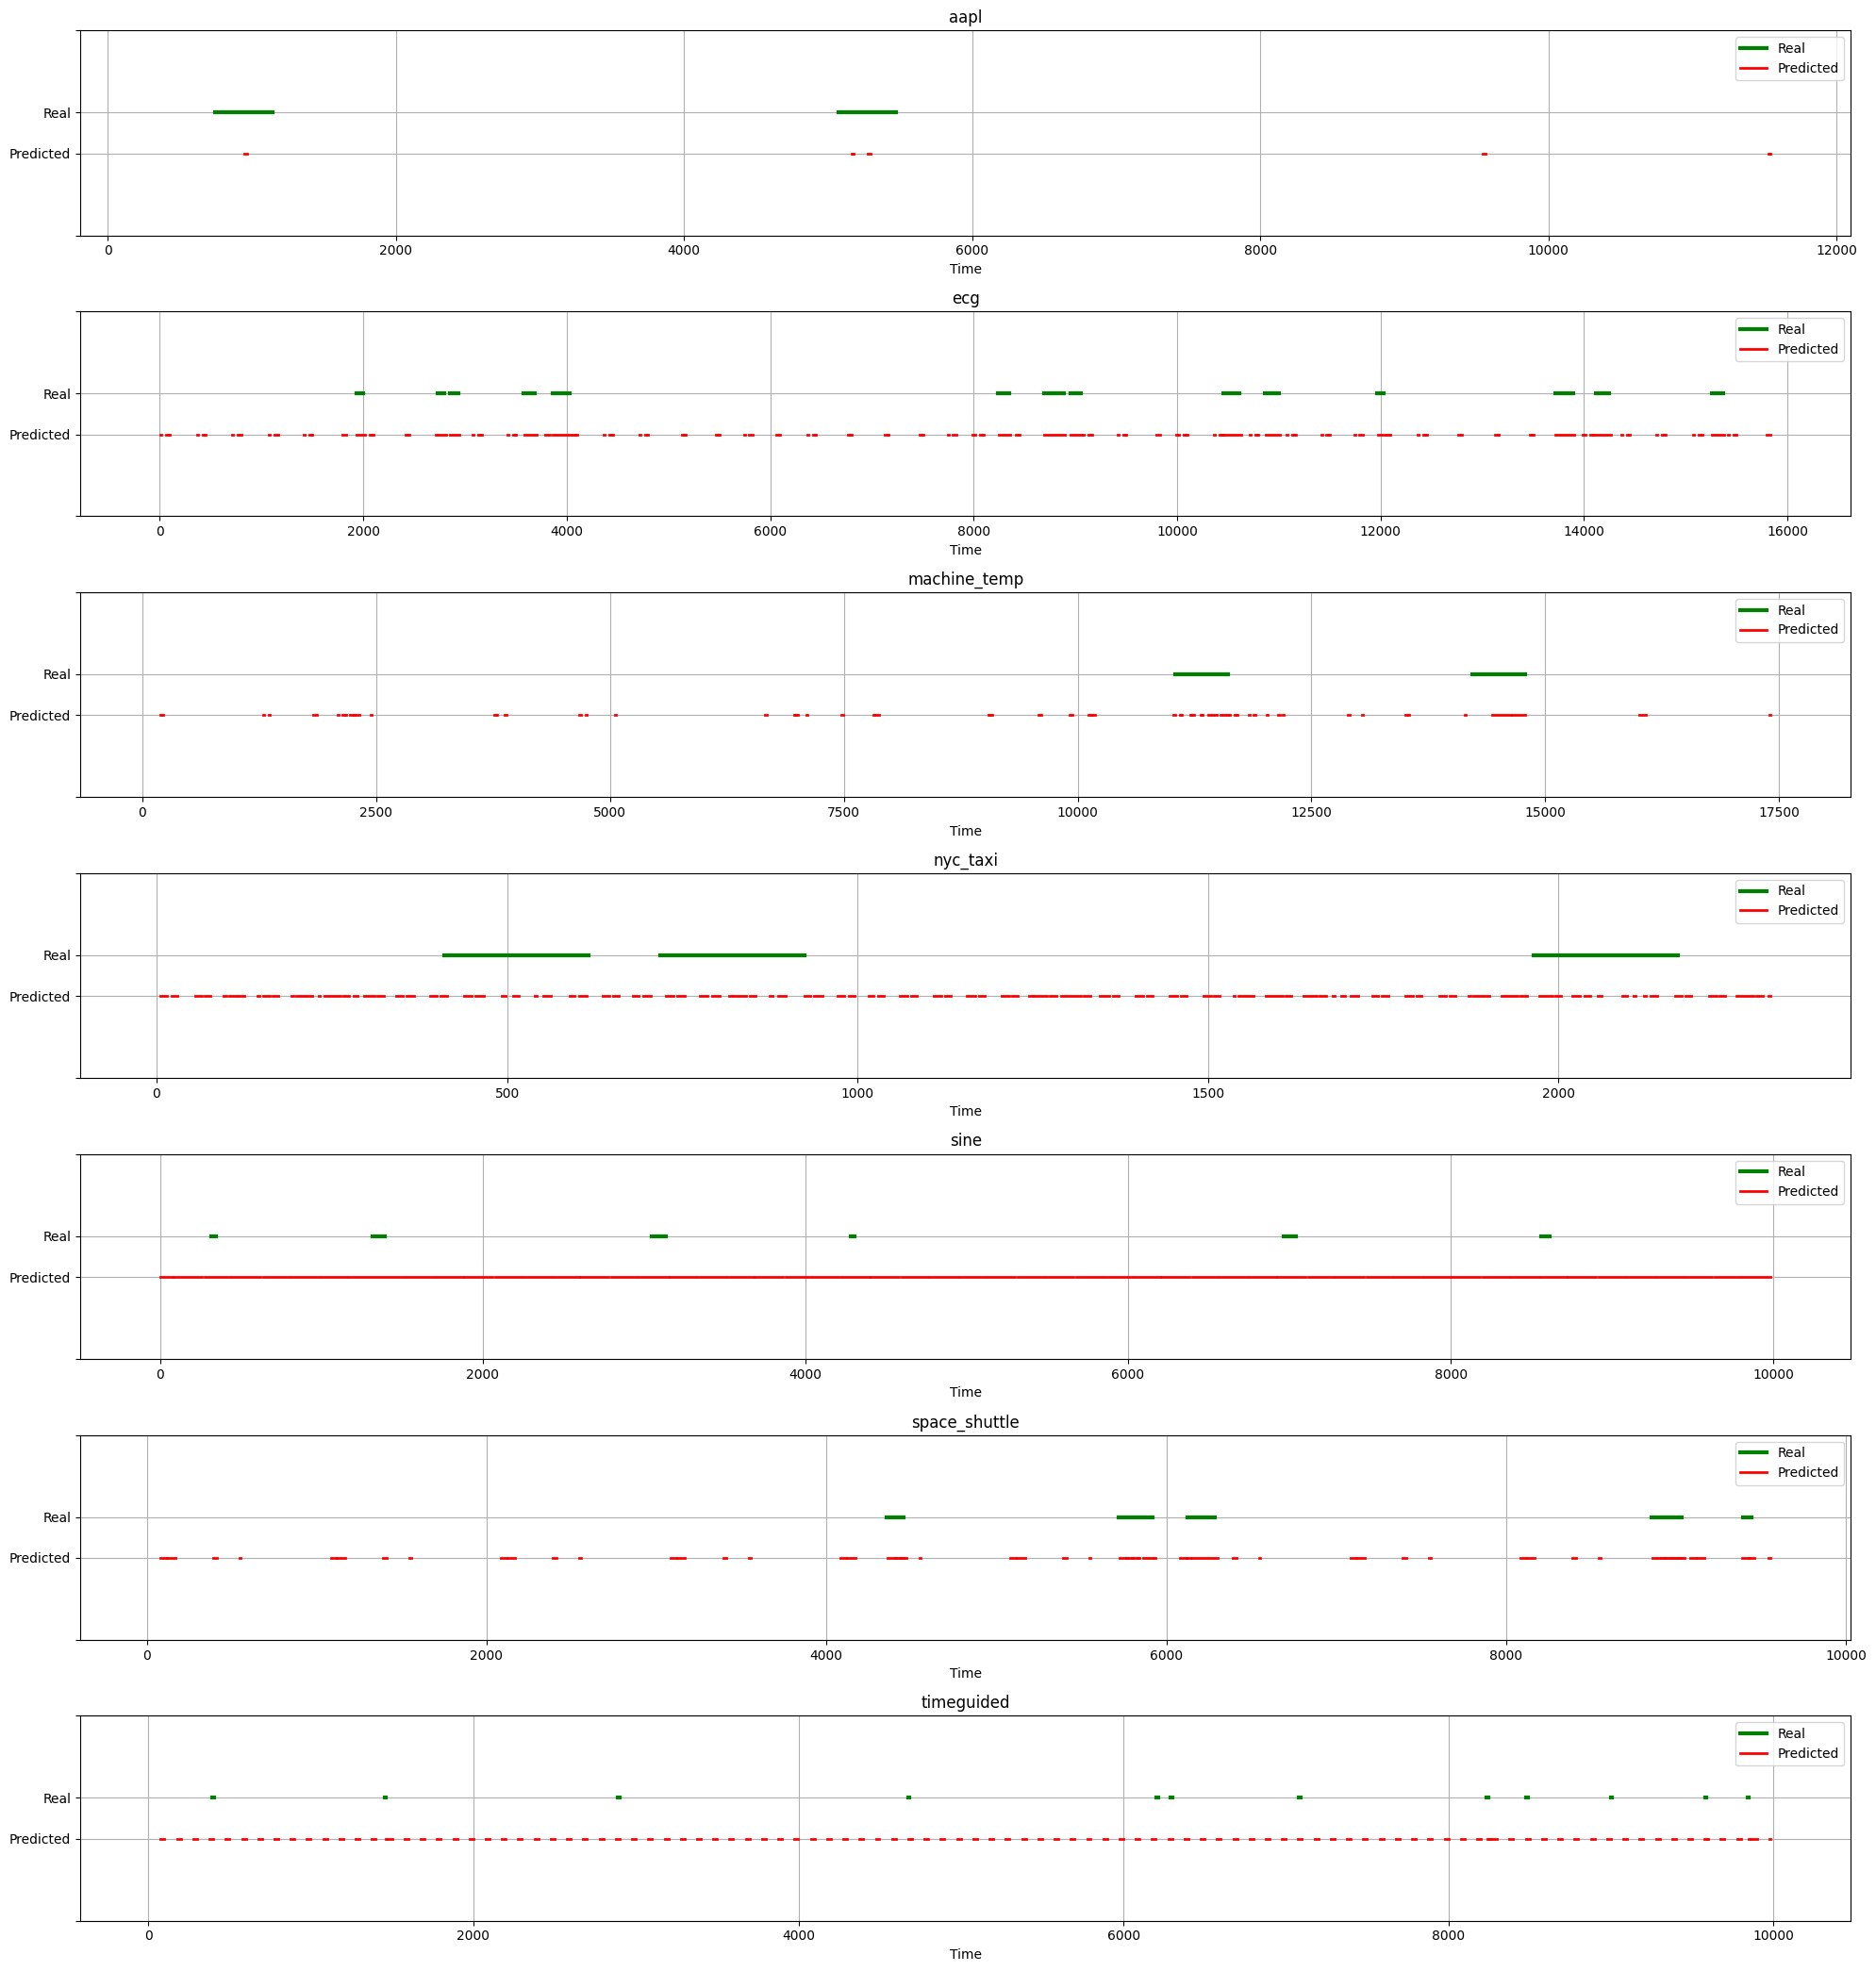

+----+---------------+------------+-----------------+----------------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------+----------+-------------------+
|    | Dataset       |   Num Real |   Num Predicted |   Real Anomalies Predicted |   Real Avg Length |   Real Min Length |   Real Max Length |   Pred Avg Length |   Pred Min Length |   Pred Max Length |   Precision |   Recall |   Avg Cardinality |
+====+===============+============+=================+============================+===================+===================+===================+===================+===================+===================+=============+==========+===================+
|  0 | aapl          |          2 |              19 |                          2 |            397    |               397 |               397 |              5.32 |                 1 |                22 |        0.5  |     0.06 |              2.5  |
+----+--

In [14]:
data_analysis(greenhouse_data)

### **Luminol Predictions**

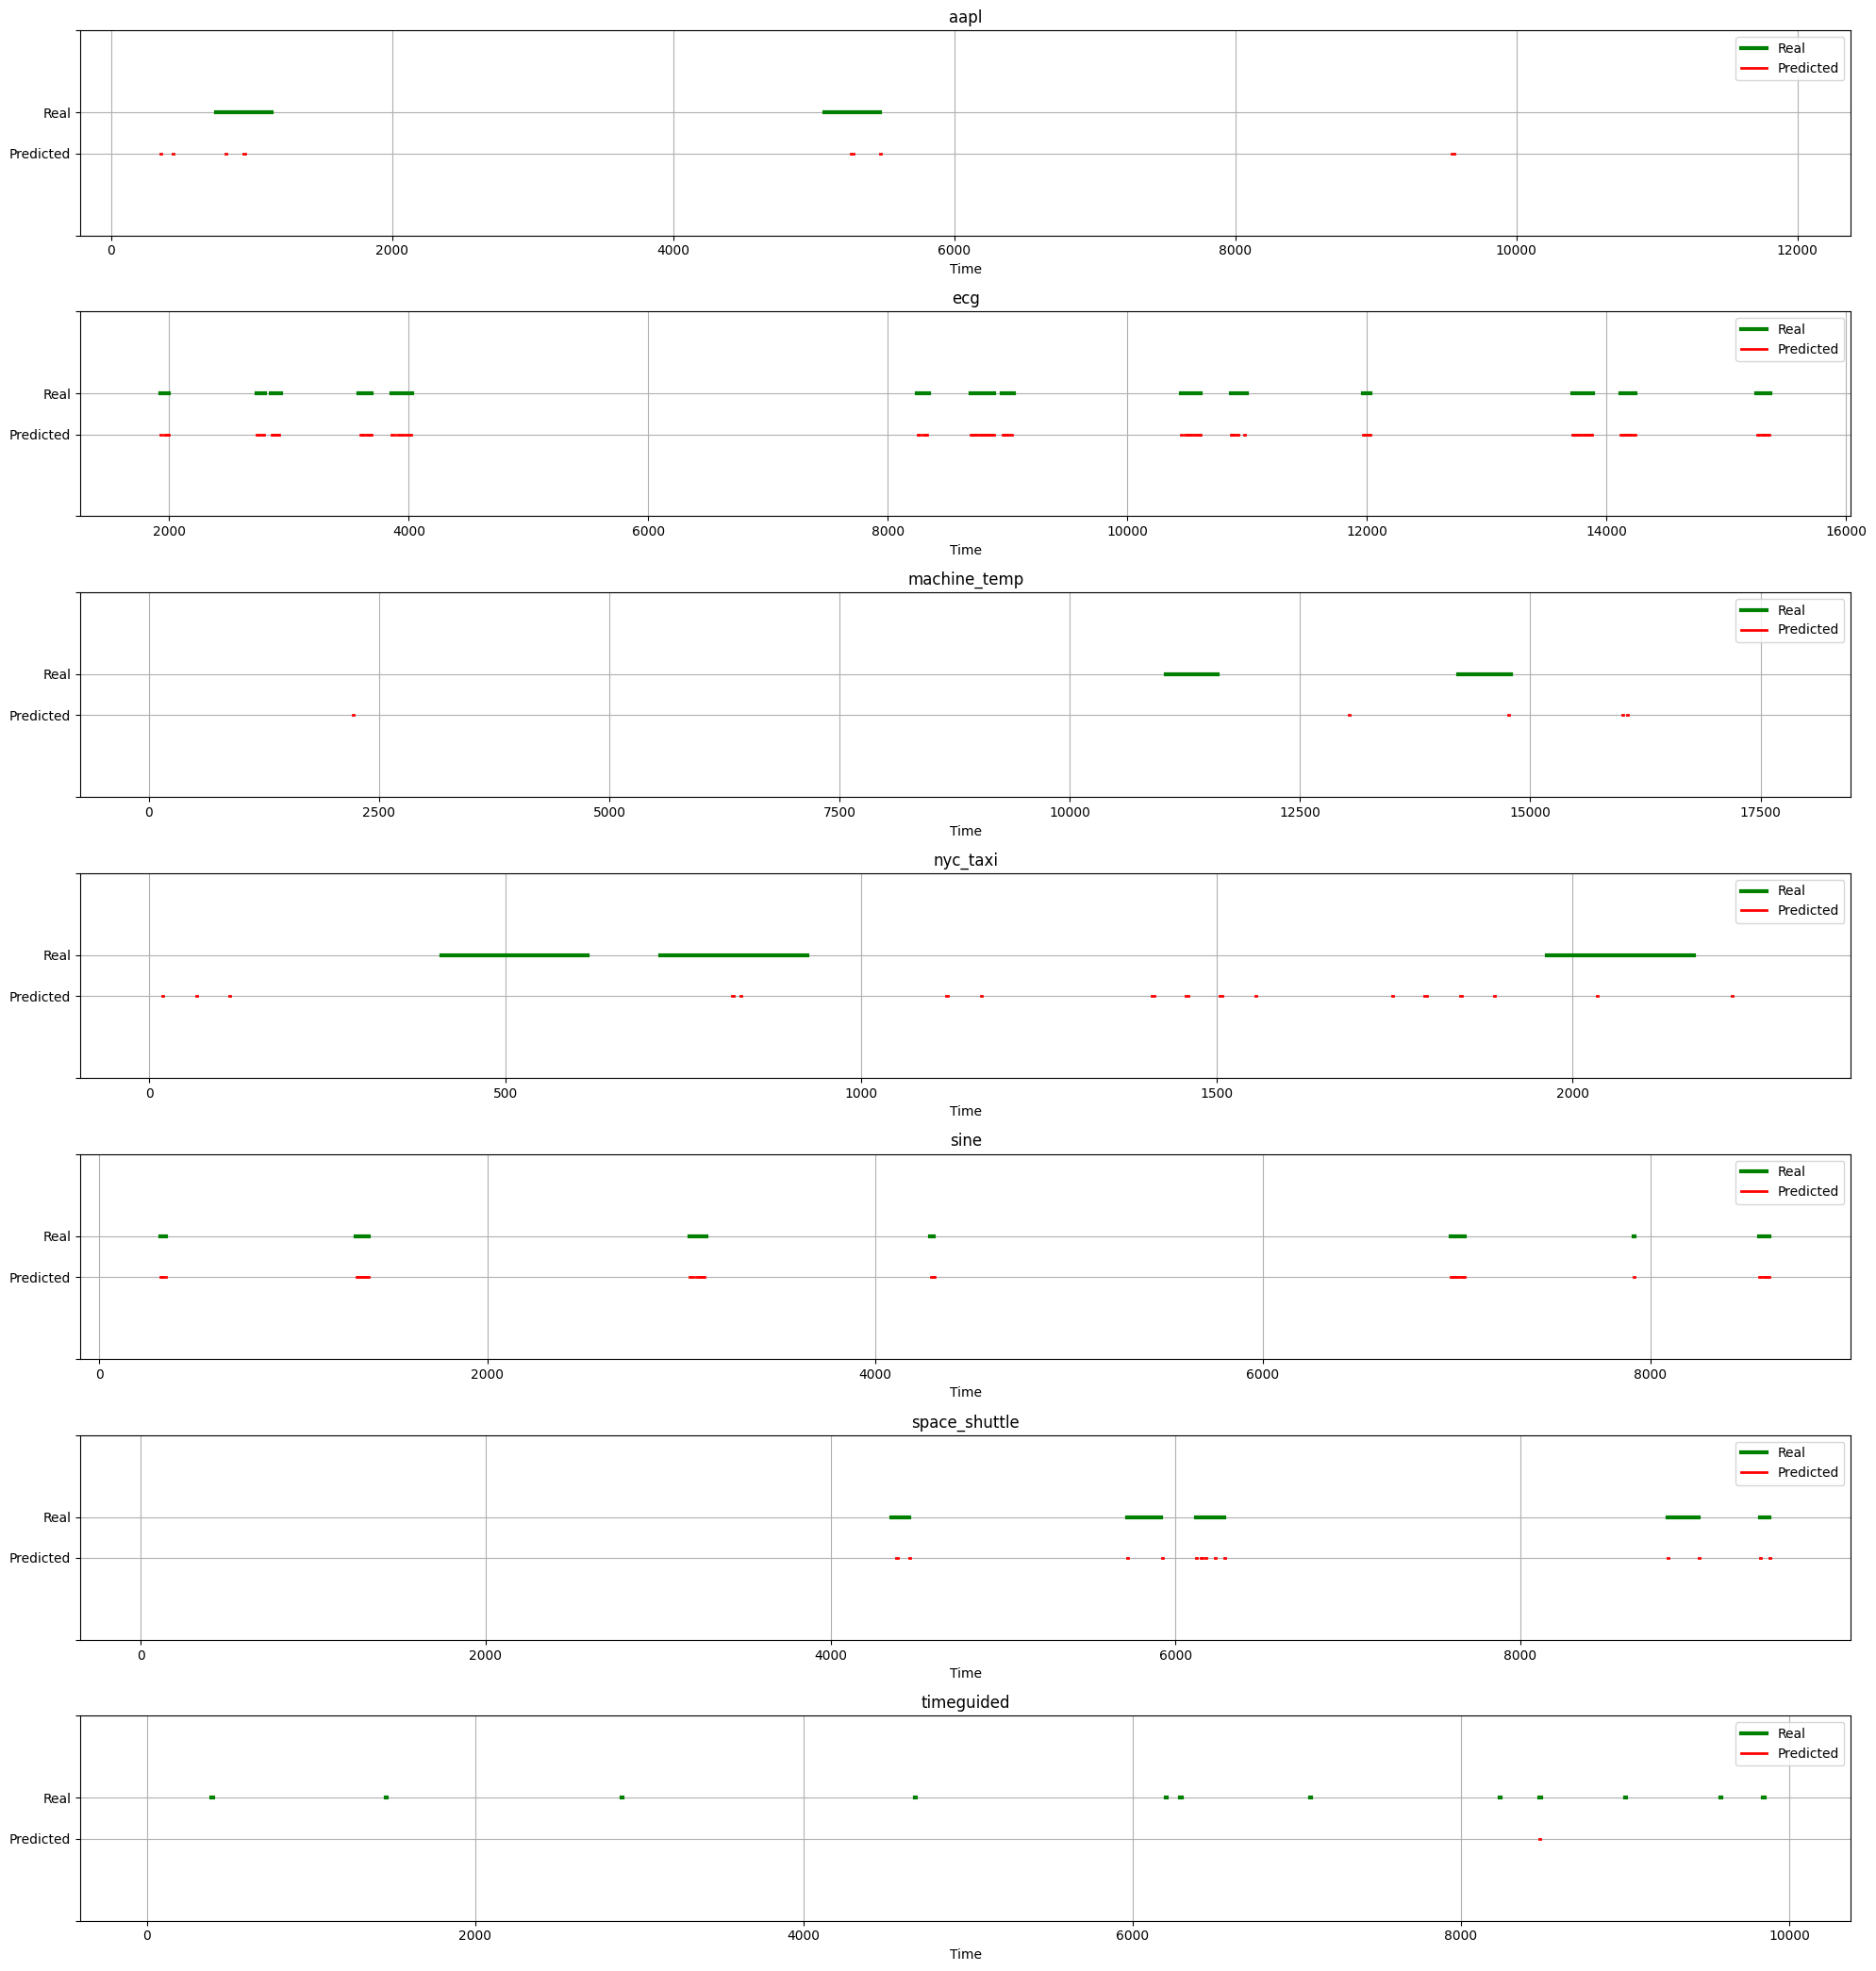

+----+---------------+------------+-----------------+----------------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------+----------+-------------------+
|    | Dataset       |   Num Real |   Num Predicted |   Real Anomalies Predicted |   Real Avg Length |   Real Min Length |   Real Max Length |   Pred Avg Length |   Pred Min Length |   Pred Max Length |   Precision |   Recall |   Avg Cardinality |
+====+===============+============+=================+============================+===================+===================+===================+===================+===================+===================+=============+==========+===================+
|  0 | aapl          |          2 |              55 |                          2 |            397    |               397 |               397 |              2.56 |                 1 |                22 |        0.37 |     0.07 |              6.5  |
+----+--

In [15]:
data_analysis(luminol_data)

## **Experiments**

### **Comparison to the classical point-based model**

The goal of this first comparison is twofold: first, to show that the new scoring model subsumes the old one, and second, to highlight the additional variations in anomaly ranges that the new model can capture.

The parameters used are: 

- For the T_Classical metrics: $\alpha = 0$, $\gamma()=1$ and $\delta=\text{Flat}$ .
- For others: $\alpha = 0$, $\gamma()=1/x$ and $\delta=\text{Flat}$ 

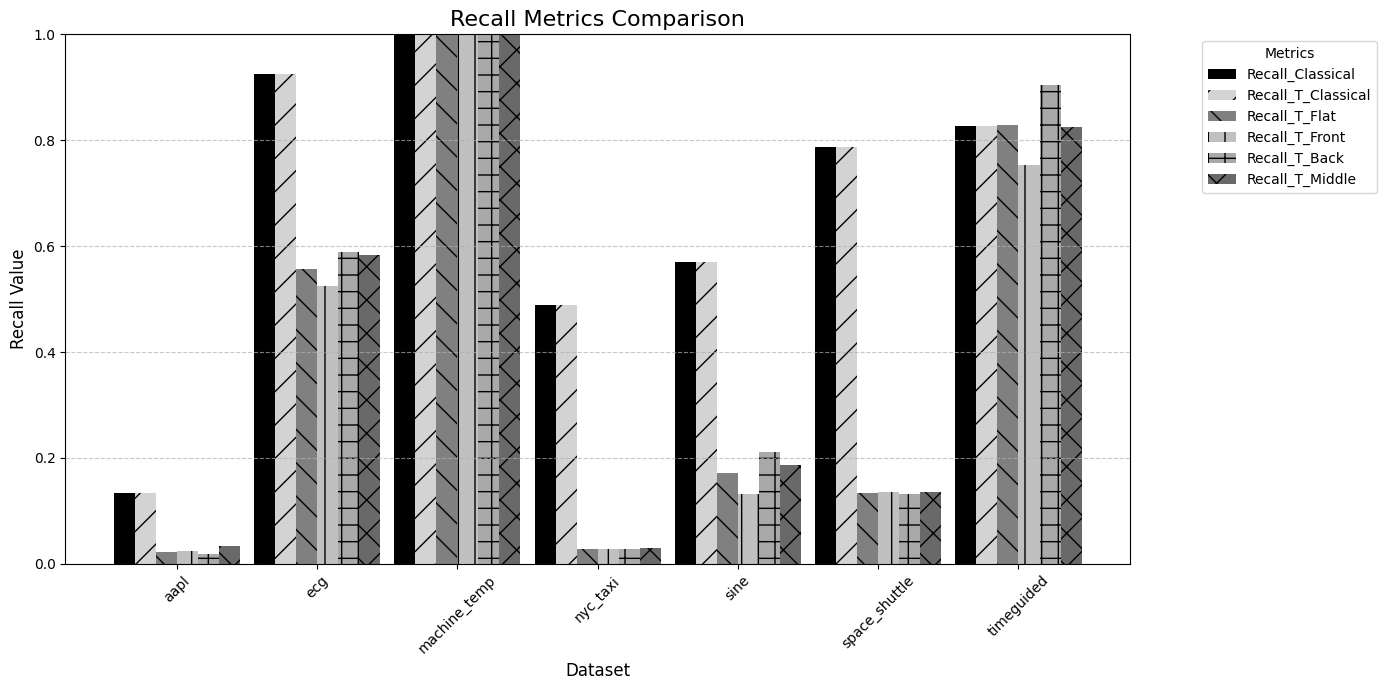

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score

# Placeholder for storing recall values
datasets = ["aapl", "ecg", "machine_temp", "nyc_taxi", "sine", "space_shuttle", "timeguided"]
recall_metrics = {dataset: {} for dataset in datasets}

# Iterate through datasets
for dataset in datasets:
    # Replace these with the actual data for the dataset
    real_anomalies = lstm_ad_data[dataset]["real_ranges"]  # Use range-based for Evaluator
    predicted_anomalies = lstm_ad_data[dataset]["pred_ranges"]

    real_points = lstm_ad_data[dataset]["real_points"]  # Use point-based for Classical metrics
    predicted_points = lstm_ad_data[dataset]["pred_points"]

    # Recall_Classical using sklearn
    recall_metrics[dataset]["Recall_Classical"] = recall_score(lstm_ad_data[dataset]["real_binary"],lstm_ad_data[dataset]["pred_binary"])

    # Recall_T_Classical 
    evaluator = Evaluator(real_points, predicted_points)
    recall_metrics[dataset]["Recall_T_Classical"] = evaluator.compute_recall()

    # Recall_T_Flat using Evaluator
    evaluator = Evaluator(real_anomalies, predicted_anomalies, gamma_r='reciprocal', delta_r="flat")
    recall_metrics[dataset]["Recall_T_Flat"] = evaluator.compute_recall()

    # Recall_T_Front
    evaluator = Evaluator(real_anomalies, predicted_anomalies, gamma_r='reciprocal', delta_r="front")
    recall_metrics[dataset]["Recall_T_Front"] = evaluator.compute_recall()

    # Recall_T_Back
    evaluator = Evaluator(real_anomalies, predicted_anomalies, gamma_r='reciprocal', delta_r="back")
    recall_metrics[dataset]["Recall_T_Back"] = evaluator.compute_recall()

    # Recall_T_Middle
    evaluator = Evaluator(real_anomalies, predicted_anomalies, gamma_r='reciprocal',delta_r="middle")
    recall_metrics[dataset]["Recall_T_Middle"] = evaluator.compute_recall()

# Plotting
metrics = ["Recall_Classical", "Recall_T_Classical", "Recall_T_Flat", "Recall_T_Front", "Recall_T_Back", "Recall_T_Middle"]

x = np.arange(len(datasets))  # Dataset indices
width = 0.15  # Bar width

fig, ax = plt.subplots(figsize=(14, 7))

# Generate bars for each metric
colors = ["black", "lightgray", "gray", "silver", "darkgray", "dimgray"]
patterns = ["-", "/", "\\", "|", "+", "x"]

for i, metric in enumerate(metrics):
    values = [recall_metrics[dataset][metric] for dataset in datasets]
    ax.bar(x + i * width, values, width, label=metric, color=colors[i], hatch=patterns[i])

# Formatting the plot
ax.set_xlabel("Dataset", fontsize=12)
ax.set_ylabel("Recall Value", fontsize=12)
ax.set_title("Recall Metrics Comparison", fontsize=16)
ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(datasets, rotation=45, fontsize=10)
ax.set_ylim(0, 1)
ax.legend(title="Metrics", loc="upper center", bbox_to_anchor=(1.15, 1), fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Comments :** 

- First, we observe that the first two bars are equal across all datasets, indicating that the new Recall score subsumes the classical Recall.
- Except for the timeguided and machine_temp datasets, $Recall_T$ is smaller than $Recall$ in all other datasets. This is because the overlap reward is not fully earned, and anomalies are often captured by more than one predicted anomaly, resulting in a penalized score due to the cardinality factor.
- For the machine_temp dataset, the recall is perfect as all anomaly ranges were entirely detected by a single range ($x=1$ in the cardinality factor).
- Regarding the timeguided dataset, 12 ranges were detected—some fully and others partially—each by a single predicted range. Partially predicted ranges were located near the back-ends, which explains why $Recall_{T_Back}$ has a higher value than others. This behavior is significant in cases where detecting delayed anomalies, such as robotic defense systems with delayed responses, is more critical—a scenario not effectively captured by the classical model.

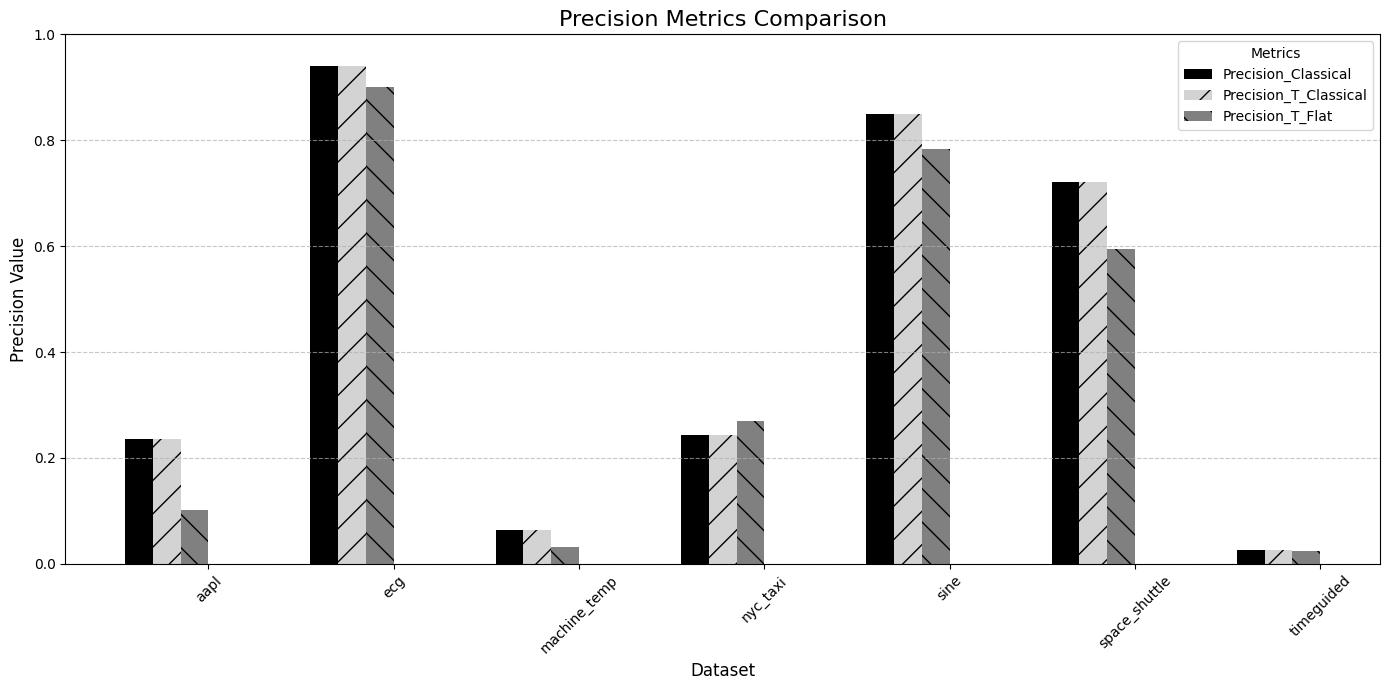

In [17]:
precision_metrics = {dataset: {} for dataset in datasets}

# Iterate through datasets
for dataset in datasets:
    # Replace these with the actual data for the dataset
    real_anomalies = lstm_ad_data[dataset]["real_ranges"]  # Use range-based for Evaluator
    predicted_anomalies = lstm_ad_data[dataset]["pred_ranges"]

    real_points = lstm_ad_data[dataset]["real_points"]  # Use point-based for Classical metrics
    predicted_points = lstm_ad_data[dataset]["pred_points"]

    # Precision_Classical using sklearn
    precision_metrics[dataset]["Precision_Classical"] = precision_score(lstm_ad_data[dataset]["real_binary"],lstm_ad_data[dataset]["pred_binary"])

    # Precision_T_Classical 
    evaluator = Evaluator(real_points, predicted_points)
    precision_metrics[dataset]["Precision_T_Classical"] = evaluator.compute_precision()

    # Precision_T_Flat 
    evaluator = Evaluator(real_anomalies, predicted_anomalies, gamma_p='reciprocal', delta_p="flat")
    precision_metrics[dataset]["Precision_T_Flat"] = evaluator.compute_precision()

    # Precision_T_Front
    evaluator = Evaluator(real_anomalies, predicted_anomalies, gamma_p='reciprocal', delta_p="front")
    precision_metrics[dataset]["Precision_T_Front"] = evaluator.compute_precision()

    # Precision_T_Back
    evaluator = Evaluator(real_anomalies, predicted_anomalies, gamma_p='reciprocal', delta_p="back")
    precision_metrics[dataset]["Precision_T_Back"] = evaluator.compute_precision()

    # Precision_T_Middle
    evaluator = Evaluator(real_anomalies, predicted_anomalies, gamma_p='reciprocal',delta_p="middle")
    precision_metrics[dataset]["Precision_T_Middle"] = evaluator.compute_precision()



# Plotting
metrics = ["Precision_Classical", "Precision_T_Classical", "Precision_T_Flat"]

x = np.arange(len(datasets))  # Dataset indices
width = 0.15  # Bar width

fig, ax = plt.subplots(figsize=(14, 7))

# Generate bars for each metric
colors = ["black", "lightgray", "gray", "silver", "darkgray", "dimgray"]
patterns = ["-", "/", "\\", "|", "+", "x"]

for i, metric in enumerate(metrics):
    values = [precision_metrics[dataset][metric] for dataset in datasets]
    ax.bar(x + i * width, values, width, label=metric, color=colors[i], hatch=patterns[i])

# Formatting the plot
ax.set_xlabel("Dataset", fontsize=12)
ax.set_ylabel("Precision Value", fontsize=12)
ax.set_title("Precision Metrics Comparison", fontsize=16)
ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(datasets, rotation=45, fontsize=10)
ax.set_ylim(0, 1)
ax.legend(title="Metrics", loc="upper right", fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Comments :** 

- We will focus only on the flat bias, as false alarms (FP) are generally considered uniformly bad regardless of when they occur.
- The same remark applies as before: the new Precision score subsumes the point-based one.
- Except for Time-Guided and NYC-Taxi, $Precision_T$ is smaller than the point-based score.
- For the Time-Guided dataset, precision values are similar due to narrow real and predicted anomaly ranges, minimizing the distinction between point- and range-based metrics. In NYC-Taxi, narrow predictions against wide real anomalies result in many false positives. However, $Precision_T$ slightly exceeds traditional Precision because the predicted anomaly ranges $N_p$ are fewer in number compared to the total points contained within those $N_p$ ranges.

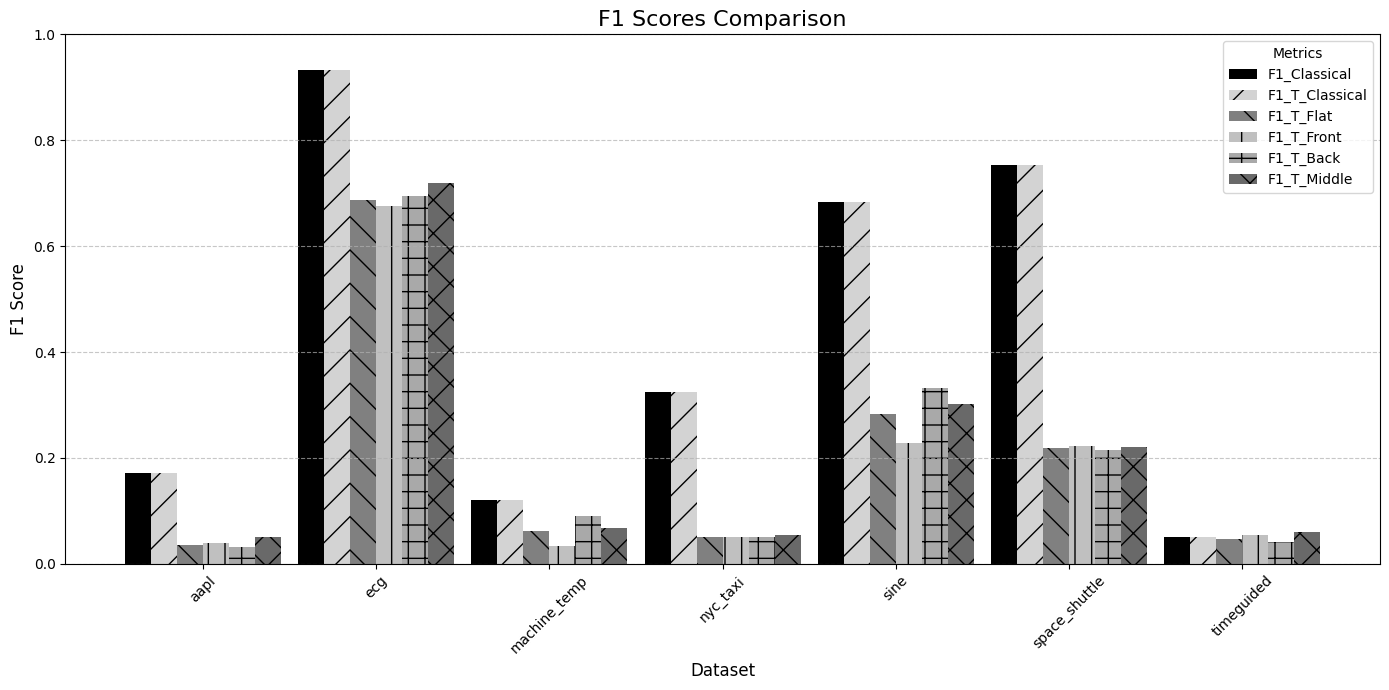

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define the metrics for F1 scores
metrics = [
    "Precision_Classical", 
    "Precision_T_Classical", 
    "Precision_T_Flat", 
    "Precision_T_Front", 
    "Precision_T_Back", 
    "Precision_T_Middle"
]

# Compute F1 scores from precision and recall metrics
f1_scores = {dataset: {} for dataset in datasets}

for dataset in datasets:
    for metric in metrics:
        precision = precision_metrics[dataset].get(metric, 0)
        # Construct the corresponding recall metric name by keeping everything after '_'
        recall_metric = f"Recall_{metric.split('Precision_')[1]}"
        recall = recall_metrics[dataset].get(recall_metric, 0)
        
        # Calculate F1 score
        if precision + recall != 0:
            f1_scores[dataset][f"F1_{metric}"] = 2 * (precision * recall) / (precision + recall)
        else:
            f1_scores[dataset][f"F1_{metric}"] = 0  # Avoid division by zero

# Bar plot for F1 scores
x = np.arange(len(datasets))  # Dataset indices
width = 0.15  # Bar width

# Define bar colors and hatch patterns for differentiation
colors = ["black", "lightgray", "gray", "silver", "darkgray", "dimgray"]
patterns = ["-", "/", "\\", "|", "+", "x"]

fig, ax = plt.subplots(figsize=(14, 7))

# Generate bars for each metric
for i, metric in enumerate(metrics):
    # Fetch F1 scores for each dataset and metric
    f1_values = [f1_scores[dataset].get(f"F1_{metric}", 0) for dataset in datasets]
    
    # Plot each bar
    ax.bar(x + i * width, f1_values, width, label=f"F1_{metric.split('Precision_')[1]}", color=colors[i], hatch=patterns[i])

# Formatting the plot
ax.set_xlabel("Dataset", fontsize=12)
ax.set_ylabel("F1 Score", fontsize=12)
ax.set_title("F1 Scores Comparison", fontsize=16)
ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(datasets, rotation=45, fontsize=10)
ax.set_ylim(0, 1)  # F1 score ranges between 0 and 1
ax.legend(title="Metrics", loc="upper right", fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


**Comments :** 

- The $F1$-score exhibits a similar behavior regarding positional bias as Recall, meaning that this combined metric (the harmonic mean of recall and precision) is as expressive as the other metrics for range-based anomaly detection evaluation.

### **Comparison to the Numenta Anomaly Benchmark (NAB) scoring model**

In this section, we will compare the model to the Numenta Anomaly Benchmark (NAB) scoring model, with the goal of determining whether the new model can mimic the NAB model and extend it.

To obtain metrics that are similar to NAB, we will be using :
- $\alpha=0$, $\gamma()=1$ and $\delta()=\text{Front}$ for $Recall_T$ and $\text{Flat}$ for $Precision_T$.
- $P_i$ will be represented as points instead of ranges.
- $\verb|F1_T|$ to compare it with $\verb|Numenta_Standard|$
- $\verb|F0.5_T|$ to compare it with $\verb|Numenta_Reward_Low_FP|$
- $\verb|F2_T|$ to compare it with $\verb|Numenta_Reward_Low_FN|$ 

Here, we reproduce the experiments presented in the paper:

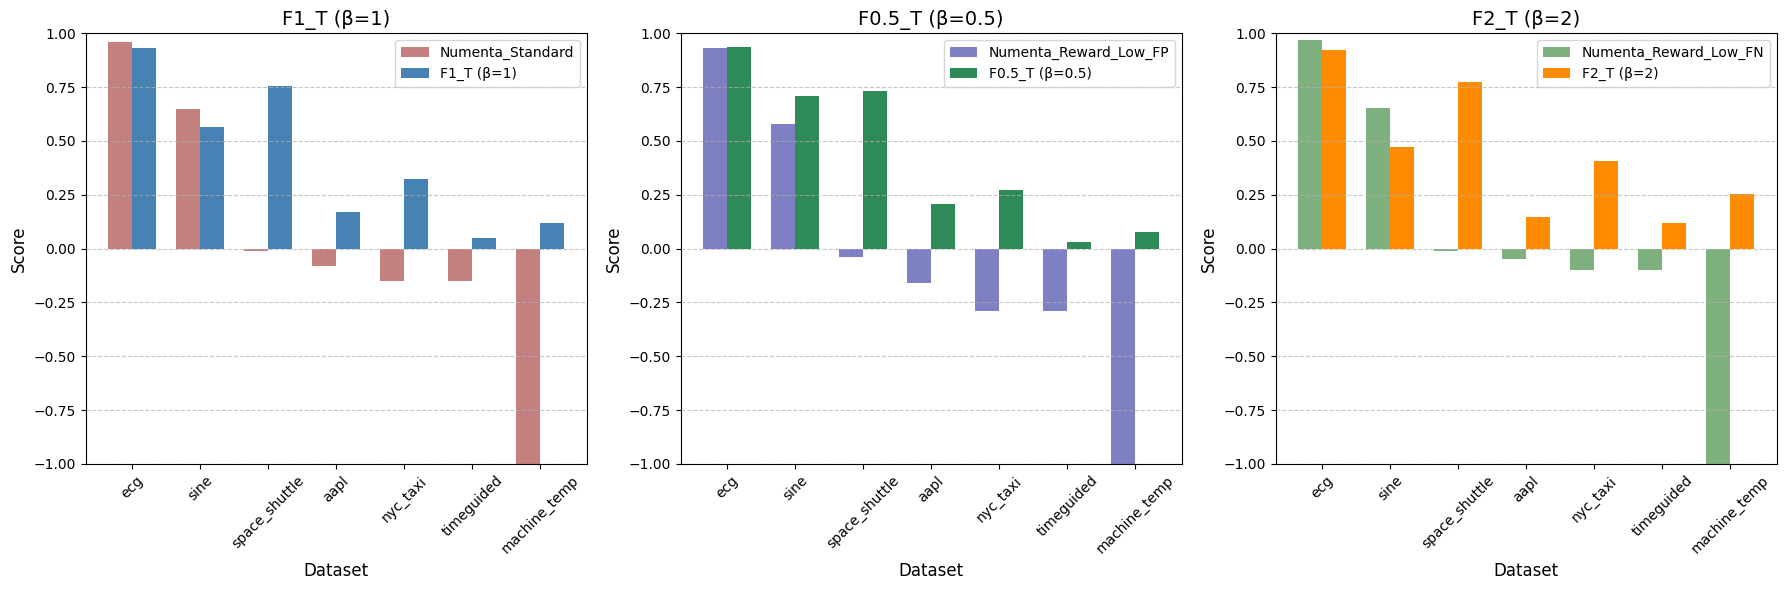

In [22]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define datasets
datasets = ["aapl", "ecg", "machine_temp", "nyc_taxi", "sine", "space_shuttle", "timeguided"]

# Initialize a dictionary to store the Fβ scores
fbeta_scores = {dataset: {'F1_T': 0, 'F0.5_T': 0, 'F2_T': 0} for dataset in datasets}

# Load Numenta scores from the CSV file
numenta_scores = pd.read_csv('datasets/numenta_results.csv', index_col='dataset')

# Recompute precision and recall for each dataset using Evaluator
for dataset in datasets:
    # Extract the range-based real anomalies and point-based predicted anomalies
    real_anomalies = lstm_ad_data[dataset]["real_ranges"]  # Range-based real anomalies
    predicted_anomalies = lstm_ad_data[dataset]["pred_points"]  # Point-based predicted anomalies

    # Compute Precision_T_Flat using Evaluator (point-based predictions, range-based real anomalies)
    evaluator = Evaluator(real_anomalies, predicted_anomalies, gamma_p='one', delta_p="flat")
    precision_t_flat = evaluator.compute_precision()  # Precision for T_Flat

    # Compute Recall_T_Front using Evaluator (point-based predictions, range-based real anomalies)
    evaluator = Evaluator(real_anomalies, predicted_anomalies, gamma_p='one', delta_p="front")
    recall_t_front = evaluator.compute_recall()  # Recall for T_Front

    # Now compute the Fβ scores for each dataset using the correct precision and recall
    # Compute F1_T (β=1)
    fbeta_scores[dataset]['F1_T'] = 2 * (precision_t_flat * recall_t_front) / (precision_t_flat + recall_t_front) if precision_t_flat + recall_t_front != 0 else 0 

    # Compute F0.5_T (β=0.5)
    fbeta_scores[dataset]['F0.5_T'] = (1 + 0.25) * (precision_t_flat * recall_t_front) / (0.25*precision_t_flat + recall_t_front) if precision_t_flat + recall_t_front != 0 else 0

    # Compute F2_T (β=2)
    fbeta_scores[dataset]['F2_T'] = (1 + 4) * (precision_t_flat * recall_t_front) / (4*precision_t_flat + recall_t_front) if precision_t_flat + recall_t_front != 0 else 0

# Sort the datasets by the Numenta_Standard score in descending order
sorted_datasets = numenta_scores['Numenta_Standard'].sort_values(ascending=False).index

# Reorder the fbeta_scores and Numenta scores according to the sorted datasets
f1_values = [fbeta_scores[dataset]['F1_T'] for dataset in sorted_datasets]
f0_5_values = [fbeta_scores[dataset]['F0.5_T'] for dataset in sorted_datasets]
f2_values = [fbeta_scores[dataset]['F2_T'] for dataset in sorted_datasets]
numenta_standard_values = [numenta_scores.loc[dataset, 'Numenta_Standard'] for dataset in sorted_datasets]
numenta_low_fp_values = [numenta_scores.loc[dataset, 'Numenta_Reward_Low_FP'] for dataset in sorted_datasets]
numenta_low_fn_values = [numenta_scores.loc[dataset, 'Numenta_Reward_Low_FN'] for dataset in sorted_datasets]

# Create 3 subplots in a row
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Define the width of each bar
bar_width = 0.35

# X positions for the sorted datasets
x_pos = np.arange(len(sorted_datasets))

# Plot F1_T (β=1) with Numenta_Standard
ax[0].bar(x_pos - bar_width/2, numenta_standard_values, color='darkred', width=bar_width, alpha=0.5, label="Numenta_Standard")
ax[0].bar(x_pos + bar_width/2, f1_values, color='steelblue', width=bar_width, label="F1_T (β=1)")
ax[0].set_title("F1_T (β=1)", fontsize=14)
ax[0].set_xticks(x_pos)
ax[0].set_xticklabels(sorted_datasets, rotation=45)
ax[0].set_xlabel("Dataset", fontsize=12)
ax[0].set_ylabel("Score", fontsize=12)  # Rotate y-axis label
ax[0].set_ylim(-1, 1)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[0].legend()

# Plot F0.5_T (β=0.5) with Numenta_Reward_Low_FP
ax[1].bar(x_pos - bar_width/2, numenta_low_fp_values, color='darkblue', width=bar_width, alpha=0.5, label="Numenta_Reward_Low_FP")
ax[1].bar(x_pos + bar_width/2, f0_5_values, color='seagreen', width=bar_width, label="F0.5_T (β=0.5)")
ax[1].set_title("F0.5_T (β=0.5)", fontsize=14)
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(sorted_datasets, rotation=45)
ax[1].set_xlabel("Dataset", fontsize=12)
ax[1].set_ylabel("Score", fontsize=12)  # Rotate y-axis label
ax[1].set_ylim(-1, 1)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].legend()

# Plot F2_T (β=2) with Numenta_Reward_Low_FN
ax[2].bar(x_pos - bar_width/2, numenta_low_fn_values, color='darkgreen', width=bar_width, alpha=0.5, label="Numenta_Reward_Low_FN")
ax[2].bar(x_pos + bar_width/2, f2_values, color='darkorange', width=bar_width, label="F2_T (β=2)")
ax[2].set_title("F2_T (β=2)", fontsize=14)
ax[2].set_xticks(x_pos)
ax[2].set_xticklabels(sorted_datasets, rotation=45)
ax[2].set_xlabel("Dataset", fontsize=12)
ax[2].set_ylabel("Score", fontsize=12)  # Rotate y-axis label
ax[2].set_ylim(-1, 1)
ax[2].grid(axis='y', linestyle='--', alpha=0.7)
ax[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


**Comments:**

- The three graphs show similar behavior, with both models decreasing from left to right, except for the Space-Shuttle dataset. This indicates that our model can mimic the behavior of the NAB scoring system.
- Let's analyze the difference between the two scores for the Space-Shuttle dataset: In this dataset, there are a few real anomaly ranges and a large number of predicted anomalies, all of which are of medium size. This resulted in a large number of both false positives and true positives. NAB severely penalizes false positives, as it favors precision over recall, which is why we observe a very small value. This suggests that NAB did not capture the relatively large recall (due to the low precision), whereas the new model captured it and produced a relatively larger value.

### **Evaluating multiple anomaly detectors**

In this section we will be evaluating and comapring the new model using different anomaly detectors : **LSTM-AD**, **Greenhouse**, and **Luminol**. 

In this experiment, we consider an application that requires early detection of anomaly ranges in a non-fragmented manner, with equal importance placed on both precision and recall. 

**Model Settings:**
- $\alpha = 0$
- $\gamma() = 1/x$ for both $Precision_T$ and $Recall_T$
- $\delta()$ is front bias for $Recall_T$ and flat bias for $Precision_T$
- $β = 1$ for $F_{β}$ score.

In comparison, Numenta's closest application profile is the **Standard** model. In the classical point-based model, the only tunable parameter is **β = 1** for the $F_{β}$ score.

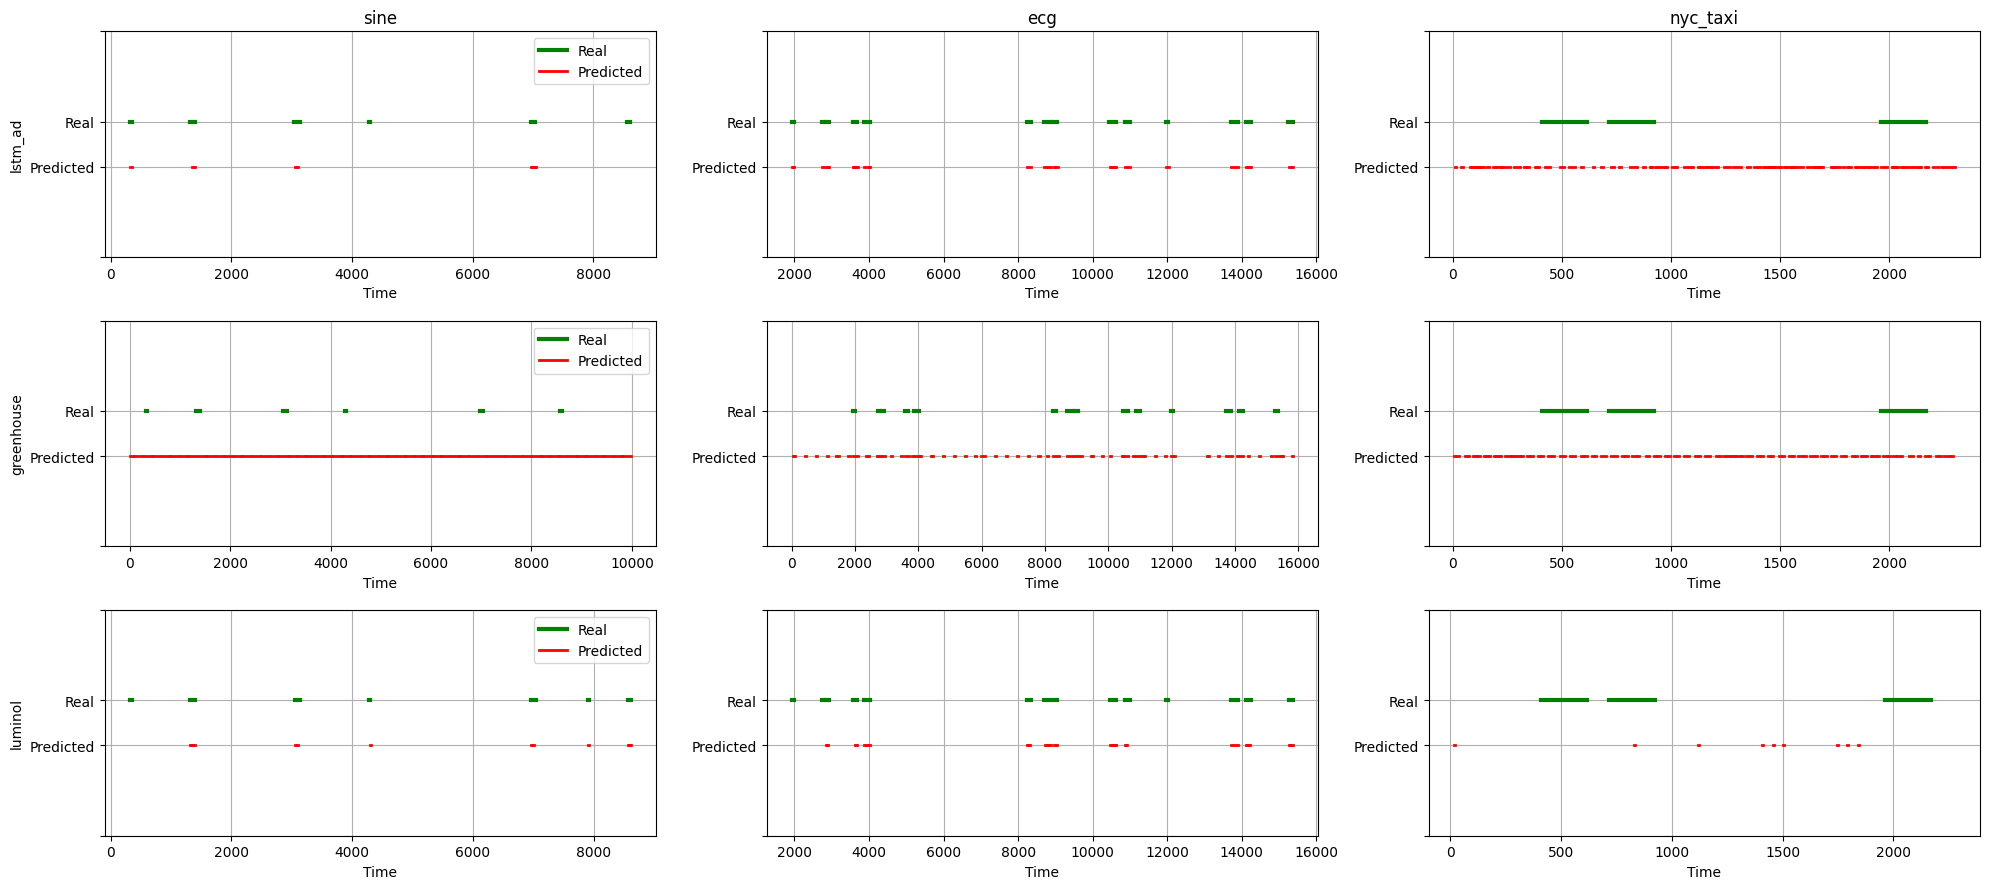

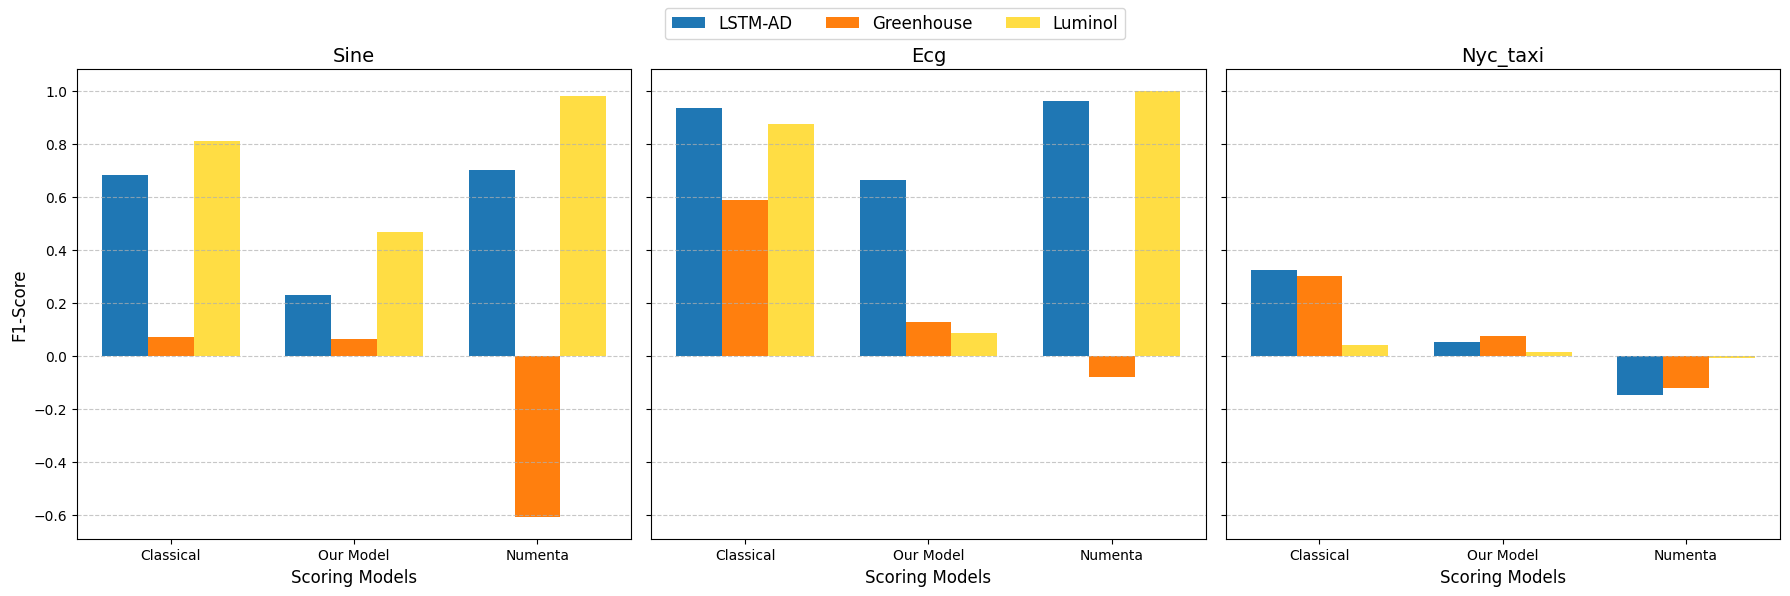

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


data = {"lstm_ad":lstm_ad_data, "greenhouse":greenhouse_data, "luminol":luminol_data}
datasets = ['sine', 'ecg', 'nyc_taxi']
anomaly_detectors = ['lstm_ad', 'greenhouse', 'luminol']

# Create figure and subplots
fig, axes = plt.subplots(len(anomaly_detectors), len(datasets), figsize=(20, 3 * len(anomaly_detectors)))

# Flatten axes array for easier indexing if there's only one row or column
if len(anomaly_detectors) == 1:
    axes = [axes]
if len(datasets) == 1:
    axes = [axes]

# Iterate over each anomaly detector and dataset
for row_idx, detector in enumerate(anomaly_detectors):
    for col_idx, dataset_name in enumerate(datasets):
        ax = axes[row_idx][col_idx]  # Current subplot
        
        data_detector = data[detector][dataset_name]  # Access the dataset for the current detector
        
        # Plot real_ranges
        for start, end in data_detector['real_ranges']:
            ax.plot([start, end], [0.6, 0.6], color='green', linewidth=3, label='Real' if start == data_detector['real_ranges'][0][0] else "")

        # Plot pred_ranges
        for start, end in data_detector['pred_ranges']:
            ax.plot([start, end], [0.4, 0.4], color='red', linewidth=2, label='Predicted' if start == data_detector['pred_ranges'][0][0] else "")

        # Set title and labels
        if row_idx == 0:
            ax.set_title(dataset_name)
        if col_idx == 0:
            ax.set_ylabel(detector)
        
        ax.set_yticks([0, 0.4, 0.6, 1])
        ax.set_yticklabels([' ', 'Predicted', 'Real', ' '])
        ax.set_xlabel('Time')
        ax.grid(True)

        # Add legend to the first subplot of each row to avoid overlap
        if col_idx == 0:
            ax.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Initialize a dictionary to store the Fβ scores for each dataset and model
fbeta_scores = {dataset: {'Classical': {'lstm_ad': 0, 'greenhouse': 0, 'luminol': 0},
                          'Our Model': {'lstm_ad': 0, 'greenhouse': 0, 'luminol': 0}} 
                for dataset in datasets}

# Load Numenta scores from the CSV file
numenta_scores = pd.read_csv('datasets/numenta_results2.csv', index_col='dataset')


# Function to calculate F1 score (for demonstration, you can replace this with actual model results)
def calculate_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

# Recompute scores for Classical and Our Model (using Evaluator for Our Model)
for dataset in datasets:
    # Classical Model (dummy precision and recall for demonstration)
    for model in ['lstm_ad', 'greenhouse', 'luminol']:
        # Replace with actual data for Classical
        predictions = data[model][dataset]["pred_binary"]
        real = data[model][dataset]["real_binary"]
        
        # Compute precision and recall for Classical model (you need to replace this with actual calculation)
        precision_classical = precision_score(real,predictions)
        recall_classical = recall_score(real,predictions)
        fbeta_scores[dataset]['Classical'][model] = calculate_f1_score(precision_classical, recall_classical)

    # Our Model (using Evaluator for precision and recall)
    for model in ['lstm_ad', 'greenhouse', 'luminol']:
        # Replace with actual data for Our Model
        predictions = data[model][dataset]["pred_ranges"]
        real_data = data[model][dataset]["real_ranges"]
        
        # Initialize Evaluator with real data and predictions (you need to replace these with actual data)
        evaluator = Evaluator(real_data, predictions, gamma_r = "reciprocal", gamma_p="reciprocal", delta_p="flat", delta_r="front")
        
        # Compute precision and recall using the Evaluator
        precision_our_model = evaluator.compute_precision()  # Replace with actual precision from evaluator
        recall_our_model = evaluator.compute_recall()        # Replace with actual recall from evaluator
        
        # Compute F1 score for Our Model
        fbeta_scores[dataset]['Our Model'][model] = calculate_f1_score(precision_our_model, recall_our_model)


# Colors for each model
colors = {
    "lstm_ad": "#1f77b4",  # Blue
    "greenhouse": "#ff7f0e",  # Orange
    "luminol": "#ffdd44"  # Yellow
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop through datasets and plot the data
for i, dataset in enumerate(datasets):
    ax = axes[i]
    
    # Bar positions
    bar_width = 0.25
    x_pos = np.arange(3)  # For scoring models: Classical, Our Model, Numenta
    
    # Extract F1 scores for the dataset
    lstm_ad_values = [
        fbeta_scores[dataset]['Classical']['lstm_ad'],
        fbeta_scores[dataset]['Our Model']['lstm_ad'],
        numenta_scores.loc[dataset, 'lstm-ad']
    ]
    greenhouse_values = [
        fbeta_scores[dataset]['Classical']['greenhouse'],
        fbeta_scores[dataset]['Our Model']['greenhouse'],
        numenta_scores.loc[dataset, 'greenhouse']
    ]
    luminol_values = [
        fbeta_scores[dataset]['Classical']['luminol'],
        fbeta_scores[dataset]['Our Model']['luminol'],
        numenta_scores.loc[dataset, 'luminol']
    ]
    
    # Plot bars for each model
    ax.bar(x_pos - bar_width, lstm_ad_values, width=bar_width, color=colors["lstm_ad"], label="LSTM-AD")
    ax.bar(x_pos, greenhouse_values, width=bar_width, color=colors["greenhouse"], label="Greenhouse")
    ax.bar(x_pos + bar_width, luminol_values, width=bar_width, color=colors["luminol"], label="Luminol")
    
    # Add labels and titles
    ax.set_title(dataset.capitalize(), fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(["Classical", "Our Model", "Numenta"])
    ax.set_xlabel("Scoring Models", fontsize=12)
    if i == 0:  # Add ylabel only for the first plot
        ax.set_ylabel("F1-Score", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
fig.legend(["LSTM-AD", "Greenhouse", "Luminol"], loc='upper center', ncol=3, fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### **Evaluating multiple anomaly detectors**

**Comments :**

- Sine Dataset: Luminol is the most accurate anomaly detector, showing the highest score, while Greenhouse is the least accurate, with the smallest score. All scoring models agree on this ranking.

- ECG Dataset: All scoring models agree that Greenhouse performs poorly, mainly due to a high number of false positives. LSTM-AD is favored by our model due to fewer, more accurate predictions, while Luminol’s excessive predictions lead to score degradation because of the cardinality factor, and this was not detected by Numenta score as it ranks Luminol first.

- NYC-Taxi Dataset: LSTM-AD and Greenhouse perform similarly, with our model favoring Greenhouse due to higher recall. Numenta strongly favors Luminol, despite it missing two anomaly range. Our model demonstrates effectiveness in evaluating anomaly detectors, capturing application requirements, and addressing data subtleties.


### **Cost analysis**


- **Naive Approach**: In the $Recall_T$ and $Precision_T$ equations, we track two sets, $R$ and $P$. A naive algorithm compares each $R_i \in R$ with all $P_j \in P$ for $Recall_T$ (and vice versa for $Precision_T$), resulting in a computational complexity of
  $$
  O(N_r \times N_p)
  $$

- **Optimization 1**: By leveraging sequential relationships between ranges, we reduce the number of comparisons. If ranges are represented as timestamp pairs ordered by their first timestamps, we iterate over $R$  and $P$ simultaneously, comparing only pairs that are close in terms of timestamps. This reduces the complexity to
  $$
  O(\max \{ N_r, N_p \})
  $$

- **Optimization 2**: To optimize the computation of positional bias functions (e.g., flat), we apply them in closed form instead of computing them for each point. This results in a single computation per range.

Here we define the class of our optimized evaluator :

In [25]:
import numpy as np

class OptimizedEvaluator:
    def __init__(self, real_anomalies, predicted_anomalies, alpha=0, gamma_p='one', gamma_r='one', delta_p='flat', delta_r='flat'):
        self.real_anomalies = sorted(real_anomalies, key=lambda x: x[0])  # Sort ranges by start time
        self.predicted_anomalies = sorted(predicted_anomalies, key=lambda x: x[0])  # Sort ranges by start time
        self.alpha_r = alpha
        self.gamma_p = gamma_p
        self.gamma_r = gamma_r
        self.delta_p = delta_p
        self.delta_r = delta_r
        self.precomputed_bias = {}  # For Optimization 2

    def delta_select(self, delta, t, anomaly_length, metric, prec_or_recall):
        if delta == 'flat':
            return 1.0
        elif delta == 'front':
            return float(anomaly_length - t + 1)
        elif delta == 'middle':
            return float(t if t <= anomaly_length / 2 else anomaly_length - t + 1)
        elif delta == 'back':
            return float(t)
        elif delta == 'udf_delta':
            return self.udf_delta_def(t, anomaly_length, metric)
        else:
            print(f"Warning: Invalid positional bias for {prec_or_recall} = {delta}. Defaulting to 'flat'.")
            return 1.0

    def precompute_positional_bias(self, anomaly_length, metric):
        """Optimization 2: Precompute positional bias functions."""
        if (anomaly_length, metric) not in self.precomputed_bias:
            self.precomputed_bias[(anomaly_length, metric)] = [
                self.delta_function(t, anomaly_length, metric) for t in range(1, anomaly_length + 1)
            ]
        return self.precomputed_bias[(anomaly_length, metric)]

    def delta_function(self, t, anomaly_length, metric):
        # Compute delta function with precomputation
        if metric == 'precision':
            return self.delta_select(self.delta_p, t, anomaly_length, metric, "precision")
        elif metric == 'recall':
            return self.delta_select(self.delta_r, t, anomaly_length, metric, "recall")
        else:
            print(f"Warning: Invalid metric {metric} in delta_function")
            return 1.0

    def gamma_function(self, overlap, metric):
        # Select the gamma value based on precision/recall
        if metric == 'precision':
            return self.gamma_select(self.gamma_p, overlap, metric, "precision")
        elif metric == 'recall':
            return self.gamma_select(self.gamma_r, overlap, metric, "recall")
        else:
            print(f"Warning: Invalid metric {metric} in gamma_function")
            return 1.0

    def compute_omega_reward(self, r1, r2, metric):
        """Optimization 1: Skip non-overlapping ranges."""
        if r1[1] < r2[0] or r1[0] > r2[1]:
            return 0
        overlap = (max(r1[0], r2[0]), min(r1[1], r2[1]))
        anomaly_length = r1[1] - r1[0] + 1
        bias = self.precompute_positional_bias(anomaly_length, metric)

        my_positional_bias = 0
        max_positional_bias = sum(bias)

        for i in range(1, anomaly_length + 1):
            j = r1[0] + i - 1
            if overlap[0] <= j <= overlap[1]:
                my_positional_bias += bias[i - 1]

        return my_positional_bias / max_positional_bias if max_positional_bias > 0 else 0

    def compute_precision(self):
        if len(self.predicted_anomalies) == 0:
            return 0.0

        precision = 0.0
        real_index = 0  # Optimization 1: Sequential iteration
        for p_start, p_end in self.predicted_anomalies:
            omega_reward = 0
            existence_reward = 0

            while real_index < len(self.real_anomalies) and self.real_anomalies[real_index][1] < p_start:
                real_index += 1

            temp_index = real_index
            while temp_index < len(self.real_anomalies) and self.real_anomalies[temp_index][0] <= p_end:
                r_start, r_end = self.real_anomalies[temp_index]
                omega_reward += self.compute_omega_reward((p_start, p_end), (r_start, r_end), 'precision')
                existence_reward = 1
                temp_index += 1

            precision += self.alpha_r * existence_reward + (1 - self.alpha_r) * omega_reward

        return precision / len(self.predicted_anomalies)

    def compute_recall(self):
        if len(self.real_anomalies) == 0:
            return 0.0

        recall = 0.0
        predicted_index = 0  # Optimization 1: Sequential iteration
        for r_start, r_end in self.real_anomalies:
            omega_reward = 0
            existence_reward = 0

            while predicted_index < len(self.predicted_anomalies) and self.predicted_anomalies[predicted_index][1] < r_start:
                predicted_index += 1

            temp_index = predicted_index
            while temp_index < len(self.predicted_anomalies) and self.predicted_anomalies[temp_index][0] <= r_end:
                p_start, p_end = self.predicted_anomalies[temp_index]
                omega_reward += self.compute_omega_reward((r_start, r_end), (p_start, p_end), 'recall')
                existence_reward = 1
                temp_index += 1

            recall += self.alpha_r * existence_reward + (1.0 - self.alpha_r) * omega_reward

        return recall / len(self.real_anomalies)


Let's generate synthetic data with an increasing number of real and predicted ranges and test both the naive and optimized models against the classical one.

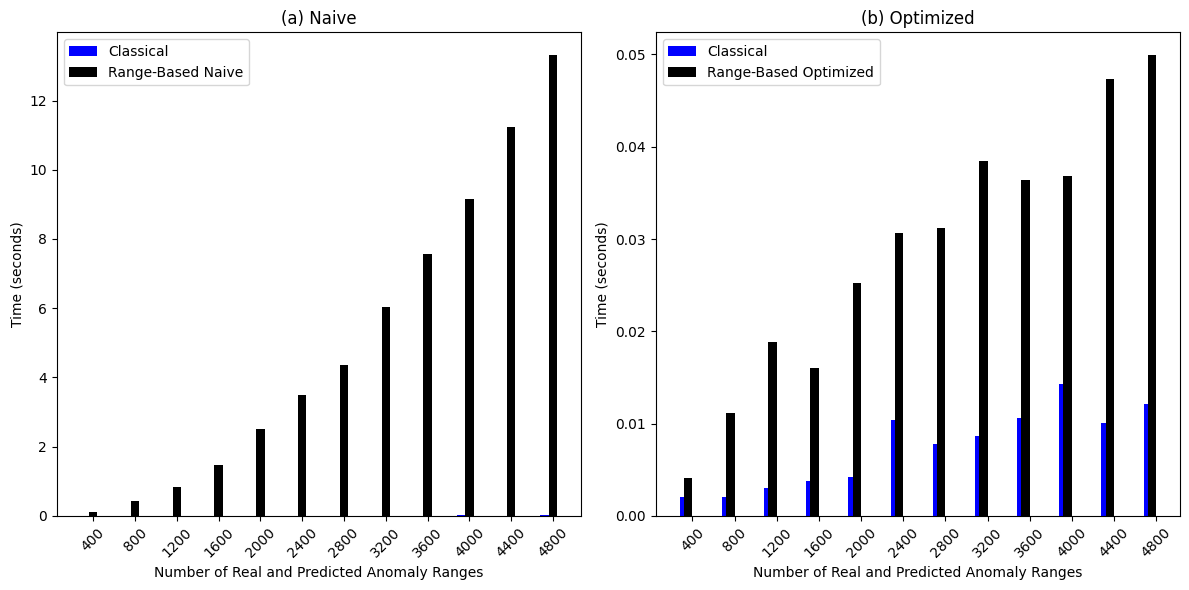

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random

# Synthetic data generation function with random range lengths
def generate_synthetic_data(num_ranges, min_range_length=5, max_range_length=15):
    real_anomalies = []
    predicted_anomalies = []
    
    for i in range(0, num_ranges * (min_range_length + max_range_length), max_range_length * 2):
        range_length = random.randint(min_range_length, max_range_length)  # Randomize range_length for each anomaly
        
        # Real anomalies: random lengths
        real_anomalies.append((i, i + range_length - 1))
        
        # Predicted anomalies
        random_offset = random.randint(0, max_range_length)
        predicted_anomalies.append((i + random_offset, i + range_length + random_offset - 1))
        
    return real_anomalies, predicted_anomalies

def ranges_to_values(ranges):
    values = []
    for start, end in ranges:
        values.extend(range(start, end + 1))  # Extend the list with values from start to end (inclusive)
    return values

# Timing function for naive classical computation
def classical_naive(real_anomalies, predicted_anomalies):
    start_time = time.time()
    real_values = set(ranges_to_values(real_anomalies))
    predicted_values = set(ranges_to_values(predicted_anomalies))
    
    # True Positives: correctly predicted anomalies
    true_positives = len(real_values & predicted_values)
    
    # Precision: fraction of predicted anomalies that are real
    precision = true_positives / len(predicted_values) if predicted_values else 0
    
    # Recall: fraction of real anomalies that are correctly predicted
    recall = true_positives / len(real_values) if real_values else 0

    end_time = time.time()
    return precision, recall, end_time - start_time

# Timing function for naive range-based computation
def range_based_naive(real_anomalies, predicted_anomalies):
    evaluator = Evaluator(real_anomalies, predicted_anomalies)
    start_time = time.time()
    precision = evaluator.compute_precision()
    recall = evaluator.compute_recall()
    end_time = time.time()
    return precision, recall, end_time - start_time

# Timing function for optimized range-based computation
def range_based_optimized(real_anomalies, predicted_anomalies):
    evaluator = OptimizedEvaluator(real_anomalies, predicted_anomalies)
    start_time = time.time()
    precision = evaluator.compute_precision()
    recall = evaluator.compute_recall()
    end_time = time.time()
    return precision, recall, end_time - start_time

# Experiment parameters
num_ranges_list = [400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400, 4800]
results = {
    "classical_naive": [],
    "range_based_naive": [],
    "range_based_optimized": []
}

# Run experiments
for num_ranges in num_ranges_list:
    real_anomalies, predicted_anomalies = generate_synthetic_data(num_ranges)

    # Classical Naive
    _, _, time_classical_naive = classical_naive(real_anomalies, predicted_anomalies)
    results["classical_naive"].append(time_classical_naive)

    # Range-Based Naive
    _, _, time_range_naive = range_based_naive(real_anomalies, predicted_anomalies)
    results["range_based_naive"].append(time_range_naive)

    # Range-Based Optimized
    _, _, time_range_optimized = range_based_optimized(real_anomalies, predicted_anomalies)
    results["range_based_optimized"].append(time_range_optimized)


# Plot results
plt.figure(figsize=(12, 6))

# Naive Plot
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(num_ranges_list)) - 0.2, results["classical_naive"], width=0.2, label="Classical", color="blue")
plt.bar(np.arange(len(num_ranges_list)), results["range_based_naive"], width=0.2, label="Range-Based Naive", color="black")
plt.xlabel("Number of Real and Predicted Anomaly Ranges")
plt.ylabel("Time (seconds)")
plt.xticks(np.arange(len(num_ranges_list)), num_ranges_list, rotation=45)
plt.legend()
plt.title("(a) Naive")

# Optimized Plot
plt.subplot(1, 2, 2)
plt.bar(np.arange(len(num_ranges_list)) - 0.2, results["classical_naive"], width=0.2, label="Classical", color="blue")
plt.bar(np.arange(len(num_ranges_list)) - 0.1, results["range_based_optimized"], width=0.2, label="Range-Based Optimized", color="black")
plt.xlabel("Number of Real and Predicted Anomaly Ranges")
plt.ylabel("Time (seconds)")
plt.xticks(np.arange(len(num_ranges_list)), num_ranges_list, rotation=45)
plt.legend()
plt.title("(b) Optimized")

plt.tight_layout()
plt.show()

**Comments :**

The first graph shows that computing precision and recall in a naive manner requires significantly more time compared to the classical model, with the computation time growing quadratically with the number of real and predicted anomaly ranges (the classical model bars are not clearly visible as they are too small). However, after optimization, we observe a significant improvement in performance, with a linear trend relative to the number of ranges. This shows that the new range-based metrics are computationally efficient, with only a minimal overhead compared to the classical metrics.